# ML prep & application for allrecipes.com project

Use functions imported from another file.

## Properties:
- input = pandas dataframe with all recipe data
- output = ML predictions on avg rating / clustering (could also do number of ratings & reviews)

## Workflow
1. Clean up the df<br>
    - remove (largely) empty columns<br>
    - fill NA<br>
    - fix up formats (datetime, float, remove units etc)<br><br>
1. Deal with language<br>
    - remove stopwords<br>
    - stem<br>
    - (tf-idf)<br>
    - NMF<br>
    - describe each word in terms of a few NMF components (eg n=10)<br><br>
1. One-hot-encode what's needed<br><br>
1. Predict number of stars / ratings / reviews<br>

## Import packages / setup

In [558]:
# import public things

# general / random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import ipynb
import re # for string parsing / editing
import string # for string parsing / editing
from datetime import datetime
import time
import random
from pathlib import Path
import os
import ast

# for html
import requests # for getting html off the web
from bs4 import BeautifulSoup # for parsing html
import json

# for ML
from wordcloud import WordCloud, STOPWORDS
import snowballstemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# import functions from my functions file
import ipynb.fs.full.functions as funcs

# update a module if it's been edited
# (this is just going around a jupyter feature where simply re-importing doesn't do anything)
# https://support.enthought.com/hc/en-us/articles/204469240-Jupyter-IPython-After-editing-a-module-changes-are-not-effective-without-kernel-restart
import importlib
importlib.reload(funcs)

# other useful settings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)

## Clean up the df

In [559]:
# input the name (which is a timestamp) of the folder for the round of interest

input_timestamp = 'joint_2021-05-11_11-28'

In [560]:
# read in the dataframe with al the recipe info from Excel file
df = pd.read_excel(f'/home/bkotryna/Allrecipes/data/{input_timestamp}/processed_recipe_data.xlsx')

# set recipe_id as index
df.set_index('recipe_id', inplace=True)

# inspect
display(df.info())
display(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 34 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   title                            3391 non-null   object 
 1   date_published                   3391 non-null   object 
 2   description                      3391 non-null   object 
 3   avg_rating                       3391 non-null   float64
 4   ratings_no                       3391 non-null   int64  
 5   recipe_cats                      3391 non-null   object 
 6   5 stars                          3391 non-null   int64  
 7   4 stars                          3391 non-null   int64  
 8   3 stars                          3391 non-null   int64  
 9   2 stars                          3391 non-null   int64  
 10  1 star                           3391 non-null   int64  
 11  reviews_no                       3391 non-null   int64  
 12  video_present   

None

title date_published  \
recipe_id                                                    
10004                               Pavlova     2019-04-04   
10007            Evelyn's Cornflake Cookies     1997-09-26   
10014                     Hazelnut Biscotti     1997-09-25   
10019       Chocolate Peanut Butter Bars II     1997-09-30   
10022                     Pignoli Cookies I     1997-10-05   
...                                     ...            ...   
87484                     German Lemon Cake     2020-06-19   
91192            French Onion Soup Gratinee     2019-04-02   
9524                          Dutch Cookies     1999-12-08   
9800                Dutch Cinnamon Biscuits     2008-06-30   
9954       French Butter Cakes (Madeleines)     2008-06-30   

                                                 description  avg_rating  \
recipe_id                                                                  
10004      My grandmother's recipe from New Zealand for t...    4.520000   
10007      I got this recipe from my  ex mother-in-law   ...    4.000000   
10014      Twice-baked cookie that can have miniature cho...    4.428571   
10019                            No-bake peanut butter bars.    4.627551   
10022      They are pleasantly sweet, made with almond pa...    4.415301   
...                                                      ...         ...   
87484      This loaf cake is known in Germany as 'Zitrone...    3.796296   
91192      About as good as it gets! This is the version ...    4.741086   
9524       This recipe has become a cherished family favo...    4.387097   
9800                             Tender with a spicy flavor.    2.750000   
9954              Sponge cake cookie--in shell shaped molds.    4.520635   

           ratings_no                                        recipe_cats  \
recipe_id                                                                  
10004              25  ['Dessert Recipes', 'Specialty Dessert Recipes...   
10007               8                     ['Dessert Recipes', 'Cookies']   
10014              14  ['Dessert Recipes', 'Cookies', 'Nut Cookie Rec...   
10019             196  ['Dessert Recipes', 'Cookies', 'Peanut Butter ...   
10022             183   ['World Cuisine Recipes', 'European', 'Italian']   
...               ...                                                ...   
87484              54    ['World Cuisine Recipes', 'European', 'German']   
91192            1823  ['Soups, Stews and Chili Recipes', 'Soup Recip...   
9524               31     ['World Cuisine Recipes', 'European', 'Dutch']   
9800                4     ['World Cuisine Recipes', 'European', 'Dutch']   
9954              315    ['World Cuisine Recipes', 'European', 'French']   

           5 stars  4 stars  3 stars  2 stars  1 star  reviews_no  \
recipe_id                                                           
10004           18        4        1        2       0          19   
10007            4        1        2        1       0           8   
10014            9        3        1        1       0          12   
10019          150       31        8        2       5         156   
10022          135       20       10        5      13         146   
...            ...      ...      ...      ...     ...         ...   
87484           22       14        8        5       5          45   
91192         1493      238       55       24      13        1251   
9524            18        9        3        0       1          26   
9800             0        1        2        0       1           4   
9954           219       62       20        7       7         247   

           video_present  photo_count  prepTime  cookTime  totalTime  \
recipe_id                                                              
10004                  0            8         0         0          0   
10007                  0            2         0         0          0   
10014                  0            4         0         0          

In [561]:
# drop empty columns

# BTW could use this to get rid of specific columns:
# df.drop([''], axis=1, inplace=True)

# drop columns that are all NA
df.dropna(axis=1, how='all', inplace=True)

# re-inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   title                          3391 non-null   object 
 1   date_published                 3391 non-null   object 
 2   description                    3391 non-null   object 
 3   avg_rating                     3391 non-null   float64
 4   ratings_no                     3391 non-null   int64  
 5   recipe_cats                    3391 non-null   object 
 6   5 stars                        3391 non-null   int64  
 7   4 stars                        3391 non-null   int64  
 8   3 stars                        3391 non-null   int64  
 9   2 stars                        3391 non-null   int64  
 10  1 star                         3391 non-null   int64  
 11  reviews_no                     3391 non-null   int64  
 12  video_present                  3391 non-null

## Dealing with publication date

In [562]:
# convert date_published from str to datetime

# first, inspect
display(type(df.iloc[0]['date_published']))

# then, convert
df['date_published'] =  pd.to_datetime(df['date_published'])

# then, re-inspect
type(df.iloc[0]['date_published'])

str

pandas._libs.tslibs.timestamps.Timestamp

In [563]:
# add recipe_age (ie time since publication) column, drop date_published column

# define what date is today (roughly)
# could use datetime.datetime.now() if wanted to have up-to-date "today", but I figure I'd rather have fixed number here atm
datetime_today = datetime(2021, 4, 27)
print(datetime_today)

# calculate recipe age
df['recipe_age'] = df['date_published'] - datetime_today
# convert recipe age to an integer number of days (I think it's always rounding down)
df['recipe_age'] = df['recipe_age'].apply(lambda x: -x.days)

# drop the original date_published column
df.drop('date_published', axis=1, inplace=True)

# inspect
display(df['recipe_age'])
display(df.info())

2021-04-27 00:00:00


recipe_id
10004     754
10007    8614
10014    8615
10019    8610
10022    8605
         ... 
87484     312
91192     756
9524     7811
9800     4684
9954     4684
Name: recipe_age, Length: 3391, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   title                          3391 non-null   object 
 1   description                    3391 non-null   object 
 2   avg_rating                     3391 non-null   float64
 3   ratings_no                     3391 non-null   int64  
 4   recipe_cats                    3391 non-null   object 
 5   5 stars                        3391 non-null   int64  
 6   4 stars                        3391 non-null   int64  
 7   3 stars                        3391 non-null   int64  
 8   2 stars                        3391 non-null   int64  
 9   1 star                         3391 non-null   int64  
 10  reviews_no                     3391 non-null   int64  
 11  video_present                  3391 non-null   int64  
 12  photo_count                    3391 non-null

None

## Transform recipe_cats & ingredient_names columns from lists to comma-separated strings

In [564]:
# transform recipe_cats & ingredient_names columns. Each cell goes from a list into a comma-seprated string

# recipe_cats
df['recipe_cats_str'] = df['recipe_cats'].apply(lambda x: x[1:-1])
df['recipe_cats_str'] = df['recipe_cats_str'].apply(lambda x: x.replace("'", ""))
display(df['recipe_cats_str'])

# ingredient_names
df['ingredient_names_str'] = df['ingredient_names'].apply(lambda x: x[1:-1])
df['ingredient_names_str'] = df['ingredient_names_str'].apply(lambda x: x.replace("'", ""))
display(df['ingredient_names_str'])

# alternative - gives a string, rather than individual strings separated by commas, as far as I can tell
# recipes_df['ingredient_names'] = recipes_df['ingredient_names'].apply(lambda x: ', '.join([str(i) for i in x]))

recipe_id
10004    Dessert Recipes, Specialty Dessert Recipes, Pa...
10007                             Dessert Recipes, Cookies
10014    Dessert Recipes, Cookies, Nut Cookie Recipes, ...
10019    Dessert Recipes, Cookies, Peanut Butter Cookie...
10022             World Cuisine Recipes, European, Italian
                               ...                        
87484              World Cuisine Recipes, European, German
91192    Soups, Stews and Chili Recipes, Soup Recipes, ...
9524                World Cuisine Recipes, European, Dutch
9800                World Cuisine Recipes, European, Dutch
9954               World Cuisine Recipes, European, French
Name: recipe_cats_str, Length: 3391, dtype: object

recipe_id
10004    egg whites, distilled white vinegar, cold wate...
10007    cream cheese, butter, white sugar, all-purpose...
10014    skinned toasted hazelnuts, white sugar, unsalt...
10019    butter, packed brown sugar, vanilla extract, p...
10022    almond paste, white sugar, confectioners sugar...
                               ...                        
87484    butter softened, white sugar, eggs, rum, all-p...
91192    butter, salt, red onions thinly, sweet onions ...
9524     butter, shortening, white sugar, all-purpose f...
9800     butter, white sugar, all-purpose flour, cinnam...
9954     eggs, vanilla extract, salt, white sugar, all-...
Name: ingredient_names_str, Length: 3391, dtype: object

## Convert recipe category lists into columns of one-hot encoding

In [565]:
# convert recipe_cats string into list
df["recipe_cats_list"]  = df["recipe_cats"].apply(ast.literal_eval)

# could expand lists into separate columns if desired
#test_df = df['recipe_cats_list'].apply(pd.Series).add_prefix('cats_')

# extract unique values from recipe_cats
unique_values = []
for index, row in df['recipe_cats_list'].iteritems():
    for item in row:
        if item not in unique_values:
            unique_values.append(item)
display(unique_values)

# make a new cat_df for manual one-hot encoding (will append this to the master df when done)
cat_df = pd.DataFrame(columns = unique_values, index=df.index)
display(cat_df)            

['Dessert Recipes',
 'Specialty Dessert Recipes',
 'Pavlova Recipes',
 'Cookies',
 'Nut Cookie Recipes',
 'Hazelnut',
 'Peanut Butter Cookie Recipes',
 'World Cuisine Recipes',
 'European',
 'Italian',
 'Drop Cookie Recipes',
 'Filled Cookie Recipes',
 'Nut Dessert Recipes',
 'Pecan Dessert Recipes',
 'No-Bake Cookie Recipes',
 'Fruit Dessert Recipes',
 'Cherry Dessert Recipes',
 'Frostings and Icings',
 'Cookie Frosting',
 'Fruit Cookie Recipes',
 'Coconut',
 'Brownie Recipes',
 'Chocolate Brownie Recipes',
 'Bar Cookie Recipes',
 'International Cookie Recipes',
 'American Cookie Recipes',
 'Fruits and Vegetables',
 'Vegetables',
 'Squash',
 'Butter Cookie Recipes',
 'Shortbread Cookie Recipes',
 'UK and Ireland',
 'Welsh',
 'Cut-Out Cookie Recipes',
 '100+ Breakfast and Brunch Recipes',
 'Sugar Cookie Recipes',
 'Dutch',
 'Almond Dessert Recipes',
 'Spice Cookie Recipes',
 'Irish',
 'Date',
 'Apricot',
 'Scandinavian',
 'Refrigerator Cookie Recipes',
 'German',
 'Chocolate Dessert Re

Dessert Recipes Specialty Dessert Recipes Pavlova Recipes Cookies  \
recipe_id                                                                     
10004                 NaN                       NaN             NaN     NaN   
10007                 NaN                       NaN             NaN     NaN   
10014                 NaN                       NaN             NaN     NaN   
10019                 NaN                       NaN             NaN     NaN   
10022                 NaN                       NaN             NaN     NaN   
...                   ...                       ...             ...     ...   
87484                 NaN                       NaN             NaN     NaN   
91192                 NaN                       NaN             NaN     NaN   
9524                  NaN                       NaN             NaN     NaN   
9800                  NaN                       NaN             NaN     NaN   
9954                  NaN                       NaN             NaN     NaN   

          Nut Cookie Recipes Hazelnut Peanut Butter Cookie Recipes  \
recipe_id                                                            
10004                    NaN      NaN                          NaN   
10007                    NaN      NaN                          NaN   
10014                    NaN      NaN                          NaN   
10019                    NaN      NaN                          NaN   
10022                    NaN      NaN                          NaN   
...                      ...      ...                          ...   
87484                    NaN      NaN                          NaN   
91192                    NaN      NaN                          NaN   
9524                     NaN      NaN                          NaN   
9800                     NaN      NaN                          NaN   
9954                     NaN      NaN                          NaN   

          World Cuisine Recipes European Italian Drop Cookie Recipes  \
recipe_id                                                              
10004                       NaN      NaN     NaN                 NaN   
10007                       NaN      NaN     NaN                 NaN   
10014                       NaN      NaN     NaN                 NaN   
10019                       NaN      NaN     NaN                 NaN   
10022                       NaN      NaN     NaN                 NaN   
...                         ...      ...     ...                 ...   
87484                       NaN      NaN     NaN                 NaN   
91192                       NaN      NaN     NaN                 NaN   
9524                        NaN      NaN     NaN                 NaN   
9800                        NaN      NaN     NaN                 NaN   
9954                        NaN      NaN     NaN                 NaN   

          Filled Cookie Recipes Nut Dessert Recipes Pecan Dessert Recipes  \
recipe_id                                                                   
10004                       NaN                 NaN                   NaN   
10007                       NaN                 NaN                   NaN   
10014                       NaN                 NaN                   NaN   
10019                       NaN                 NaN                   NaN   
10022                       NaN                 NaN                   NaN   
...                         ...                 ...                   ...   
87484                       NaN                 NaN                   NaN   
91192                       NaN                 NaN                   NaN   
9524                        NaN                 NaN                   NaN   
9800                        NaN                 NaN                   NaN   
9954                        NaN                 NaN                   NaN   

          No-Bake Cookie Recipes Fruit Dessert Recipes Cherry Dessert Recipes  \
recipe_id                                          

In [566]:
# manually one-hot encode

# add 1 if recipe belongs to a particular category
for index, row in df['recipe_cats_list'].iteritems():
    for item in row:
        for col_name in cat_df.columns:
            if item == col_name:
                cat_df.at[index, col_name] = 1

display(cat_df.info())

# replace the remaining empty (NaN) cells with zeros
cat_df.fillna(0, inplace=True)
display(cat_df.info())
display(cat_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Columns: 714 entries, Dessert Recipes to Veggie
dtypes: object(714)
memory usage: 18.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Columns: 714 entries, Dessert Recipes to Veggie
dtypes: int64(714)
memory usage: 18.7 MB


None

Dessert Recipes  Specialty Dessert Recipes  Pavlova Recipes  \
recipe_id                                                                
10004                    1                          1                1   
10007                    1                          0                0   
10014                    1                          0                0   
10019                    1                          0                0   
10022                    0                          0                0   
...                    ...                        ...              ...   
87484                    0                          0                0   
91192                    0                          0                0   
9524                     0                          0                0   
9800                     0                          0                0   
9954                     0                          0                0   

           Cookies  Nut Cookie Recipes  Hazelnut  \
recipe_id                                          
10004            0                   0         0   
10007            1                   0         0   
10014            1                   1         1   
10019            1                   0         0   
10022            0                   0         0   
...            ...                 ...       ...   
87484            0                   0         0   
91192            0                   0         0   
9524             0                   0         0   
9800             0                   0         0   
9954             0                   0         0   

           Peanut Butter Cookie Recipes  World Cuisine Recipes  European  \
recipe_id                                                                  
10004                                 0                      0         0   
10007                                 0                      0         0   
10014                                 0                      0         0   
10019                                 1                      0         0   
10022                                 0                      1         1   
...                                 ...                    ...       ...   
87484                                 0                      1         1   
91192                                 0                      0         0   
9524                                  0                      1         1   
9800                                  0                      1         1   
9954                                  0                      1         1   

           Italian  Drop Cookie Recipes  Filled Cookie Recipes  \
recipe_id                                                        
10004            0                    0                      0   
10007            0                    0                      0   
10014            0                    0                      0   
10019            0                    0                      0   
10022            1                    0                      0   
...            ...                  ...                    ...   
87484            0                    0                      0   
91192            0                    0                      0   
9524             0                    0                      0   
9800             0                    0                      0   
9954             0                    0                      0   

           Nut Dessert Recipes  Pecan Dessert Recipes  No-Bake Cookie Recipes  \
recipe_id                                                                       
10004                        0                      0                       0   
10007                        0                      0                       0   
10014                        0                      0                       0   
10019                        0                      0                       0   
10022                        0       

## Convert nutrition specs into float (strings with calories, g, mg => float)

In [567]:
# convert nutrition specs into float (strings with calories, g, mg => float)

df = funcs.remove_units(df, 'nutrition.calories', 'calories')
df = funcs.remove_units(df, 'nutrition.carbohydrateContent', 'g')
df = funcs.remove_units(df, 'nutrition.fatContent', 'g')
df = funcs.remove_units(df, 'nutrition.fiberContent', 'g')
df = funcs.remove_units(df, 'nutrition.proteinContent', 'g')
df = funcs.remove_units(df, 'nutrition.saturatedFatContent', 'g')
df = funcs.remove_units(df, 'nutrition.cholesterolContent', 'mg')
df = funcs.remove_units(df, 'nutrition.sodiumContent', 'mg')
df = funcs.remove_units(df, 'nutrition.sugarContent', 'g')

Now removing units from column:  nutrition.calories
Now removing units from column:  nutrition.carbohydrateContent
Now removing units from column:  nutrition.fatContent
Now removing units from column:  nutrition.fiberContent
Now removing units from column:  nutrition.proteinContent
Now removing units from column:  nutrition.saturatedFatContent
Now removing units from column:  nutrition.cholesterolContent
Now removing units from column:  nutrition.sodiumContent
Now removing units from column:  nutrition.sugarContent


In [568]:
# inspect
pd.set_option('display.max_rows', 5)
display(df)

# inspect some more
pd.set_option('display.max_rows', 100)
display(df.info())

title  \
recipe_id                                     
10004                               Pavlova   
10007            Evelyn's Cornflake Cookies   
...                                     ...   
9800                Dutch Cinnamon Biscuits   
9954       French Butter Cakes (Madeleines)   

                                                 description  avg_rating  \
recipe_id                                                                  
10004      My grandmother's recipe from New Zealand for t...    4.520000   
10007      I got this recipe from my  ex mother-in-law   ...    4.000000   
...                                                      ...         ...   
9800                             Tender with a spicy flavor.    2.750000   
9954              Sponge cake cookie--in shell shaped molds.    4.520635   

           ratings_no                                        recipe_cats  \
recipe_id                                                                  
10004              25  ['Dessert Recipes', 'Specialty Dessert Recipes...   
10007               8                     ['Dessert Recipes', 'Cookies']   
...               ...                                                ...   
9800                4     ['World Cuisine Recipes', 'European', 'Dutch']   
9954              315    ['World Cuisine Recipes', 'European', 'French']   

           5 stars  4 stars  3 stars  2 stars  1 star  reviews_no  \
recipe_id                                                           
10004           18        4        1        2       0          19   
10007            4        1        2        1       0           8   
...            ...      ...      ...      ...     ...         ...   
9800             0        1        2        0       1           4   
9954           219       62       20        7       7         247   

           video_present  photo_count  prepTime  cookTime  totalTime  \
recipe_id                                                              
10004                  0            8         0         0          0   
10007                  0            2         0         0          0   
...                  ...          ...       ...       ...        ...   
9800                   0            1         0         0          0   
9954                   1          137         0         0          0   

           ingredients_no                                   ingredient_names  \
recipe_id                                                                      
10004                   6  ['egg whites', 'distilled white vinegar', 'col...   
10007                   9  ['cream cheese', 'butter', 'white sugar', 'all...   
...                   ...                                                ...   
9800                    7  ['butter', 'white sugar', 'all-purpose flour',...   
9954                    8  ['eggs', 'vanilla extract', 'salt', 'white sug...   

           steps_no                                          steps_str  \
recipe_id                                                                
10004             4  Preheat oven to 300 degrees F (150 degrees C)....   
10007             3  Cream together all ingredients except cornflak...   
...             ...                                                ...   
9800              3  Preheat oven to 350 degrees F (175 degrees C)....   
9954              9  Preheat oven to 375 degrees F (190 degrees C)....   

           steps_words_no  nutrition.calories in calories  \
recipe_id                                                   
10004                 102                           108.1   
10007                  56                           195.6   
...                   ...                             ...   
9800                   92                           159.9   
9954                  202                           108.8   

           nutrition.carbohydrateContent in g  \
recipe_id                                       
10004                                    26.0  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 34 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title                               3391 non-null   object 
 1   description                         3391 non-null   object 
 2   avg_rating                          3391 non-null   float64
 3   ratings_no                          3391 non-null   int64  
 4   recipe_cats                         3391 non-null   object 
 5   5 stars                             3391 non-null   int64  
 6   4 stars                             3391 non-null   int64  
 7   3 stars                             3391 non-null   int64  
 8   2 stars                             3391 non-null   int64  
 9   1 star                              3391 non-null   int64  
 10  reviews_no                          3391 non-null   int64  
 11  video_present                       339

None

## Handle language (TF-IDF, NMF etc)

### Loop through a list of columns

In [569]:
# import things

import snowballstemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF

In [570]:
# generate a master nmf_df
nmf_df = pd.DataFrame(index=df.index)

# choose columns for NMF analysis
columns_for_nmf = ['title', 'description', 'ingredient_names_str', 'steps_str']

# do NMF analysis
for col in columns_for_nmf:
    col_nmf_df = funcs.stem_make_nmf(col, df, nmf_df, n=10)
    nmf_df = pd.concat([nmf_df, col_nmf_df], axis=1)


************
Now working on column 'title':
Stemming done
vocabulary size: 2170
Tokenising done.
Most freqeunt words are:
[('chicken', 232), ('cooki', 189), ('cake', 189), ('chocol', 146), ('salad', 145)]
NMF transforming done.

***
Component 0 for title

Most important words are:
chicken : 4.987
fri : 0.305
easi : 0.266
curri : 0.217
orang : 0.186

The entry that most strongly embodies this component is:
Chicken Fried Chicken

***
Component 1 for title

Most important words are:
cooki : 3.782
butter : 0.510
oatmeal : 0.482
sugar : 0.421
peanut : 0.411

The entry that most strongly embodies this component is:
Peanut Butter Oatmeal Cookies II

***
Component 2 for title

Most important words are:
cake : 3.358
coffe : 0.291
pound : 0.256
apple : 0.224
german : 0.171

The entry that most strongly embodies this component is:
German Apple Pudding Cake

***
Component 3 for title

Most important words are:
soup : 4.094
tomato : 0.519
bean : 0.460
onion : 0.317
lentil : 0.285

The entry that m

Stemming done
vocabulary size: 1615
Tokenising done.
Most freqeunt words are:
[('salt', 1847), ('pepper', 1794), ('sugar', 1747), ('white', 1464), ('butter', 1232)]
NMF transforming done.

***
Component 0 for ingredient_names_str

Most important words are:
pepper : 9.186
salt : 3.178
onion : 2.585
bell : 2.480
black : 2.411

The entry that most strongly embodies this component is:
butter, minced white onion, minced green onions, minced carrots, minced celery, minced green bell pepper, minced red bell pepper, minced garlic, salt, black pepper, cayenne pepper, nutmeg, cumin, eggs, ketchup, cream, turkey, chicken sausage, fresh bread crumbs, butter divided, shallots minced, minced red bell pepper, minced yellow bell pepper, sprig fresh thyme, bay leaves, freshly black pepper to, cream, minced garlic, beef stock, chicken stock, roma tomatoes - seeded, ketchup, salt freshly black pepper to

***
Component 1 for ingredient_names_str

Most important words are:
white : 5.376
sugar : 3.918
water

/home/bkotryna/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


NMF transforming done.

***
Component 0 for steps_str

Most important words are:
mix : 7.610
bowl : 5.857
mixtur : 2.750
cup : 2.144
medium : 2.128

The entry that most strongly embodies this component is:
Check your coffee mugs to make sure each one holds 1 1/2 cups water. Place dry cake mix and dry pudding mix into a large bowl and blend well with a whisk. This will be about 4 to 4 1/2 cups of dry mix and will make 8 coffee cup cake mixes. Divide mix into 8 small plastic bags (about 1/2 cup each). Place mix into a corner of each bag and tie it there with a twist tie. Make glaze mix: in a medium bowl, combine confectioners sugar with powdered flavoring mix. Divide into 8 small plastic bags and close bag with a twist tie. Attach each glaze mix to the cake mix bags with a twist tie. Place one of each bag into each cup. Attach the following instructions to each cup:  Generously spray inside of cup with cooking spray. Empty contents of cake mix packet in cup. Add 1 egg, 1 tablespoon of oi

In [571]:
nmf_df

title_nmf_0  title_nmf_1  title_nmf_2  title_nmf_3  title_nmf_4  \
recipe_id                                                                    
10004         0.000000     0.000000     0.000000     0.000000     0.000000   
10007         0.000000     0.245480     0.000000     0.000000     0.000000   
10014         0.000000     0.000000     0.001335     0.000000     0.000000   
10019         0.000000     0.050409     0.020243     0.000000     0.000000   
10022         0.000000     0.244256     0.000000     0.000000     0.000000   
...                ...          ...          ...          ...          ...   
87484         0.001126     0.000000     0.309119     0.001388     0.000000   
91192         0.000000     0.000000     0.000000     0.255226     0.000000   
9524          0.000000     0.247096     0.000000     0.000525     0.000002   
9800          0.000222     0.006028     0.009065     0.000924     0.001283   
9954          0.000000     0.028245     0.299862     0.007972     0.000000   

           title_nmf_5  title_nmf_6  title_nmf_7  title_nmf_8  title_nmf_9  \
recipe_id                                                                    
10004         0.000000     0.000000     0.000000     0.000000     0.000000   
10007         0.000000     0.000000     0.000000     0.000000     0.000000   
10014         0.002200     0.000000     0.003672     0.000000     0.000000   
10019         0.013168     0.020633     0.323757     0.000841     0.000000   
10022         0.000000     0.000000     0.000000     0.000000     0.000000   
...                ...          ...          ...          ...          ...   
87484         0.001829     0.000205     0.000925     0.000000     0.004686   
91192         0.000000     0.000000     0.000000     0.000000     0.000000   
9524          0.000000     0.002947     0.000000     0.000000     0.000869   
9800          0.000000     0.009825     0.002477     0.002550     0.006357   
9954          0.003652     0.000000     0.000000     0.000000     0.000000   

           description_nmf_0  description_nmf_1  description_nmf_2  \
recipe_id                                                            
10004               0.000000           0.000000           0.203662   
10007               0.000000           0.000000           0.217768   
10014               0.000000           0.000000           0.000000   
10019               0.000000           0.002041           0.000000   
10022               0.000000           0.003935           0.000389   
...                      ...                ...                ...   
87484               0.000000           0.000000           0.000000   
91192               0.252647           0.017584           0.014677   
9524                0.010583           0.004835           0.267109   
9800                0.000000           0.000000           0.000000   
9954                0.000000           0.000000           0.000000   

           description_nmf_3  description_nmf_4  description_nmf_5  \
recipe_id                                                            
10004               0.000000           0.000000           0.000000   
10007               0.000000           0.000000           0.000000   
10014               0.188511           0.000000           0.000000   
10019               0.000281           0.000000           0.000000   
10022               0.007353           0.002066           0.000000   
...                      ...                ...                ...   
87484               0.016919           0.000000           0.029394   
91192               0.008324           0.000000           0.002350   
9524                0.000000           0.000000           0.028092   
9800                0.000000           0.000000           0.000000   
9954                0.004200           0.000000           0.010076   

           description_nmf_6  description_nmf_7  description_nmf_8  \
recipe_id                                                            
10004              

In [572]:
# inspect output

display(df.info())
display(df.describe())

pd.set_option('display.max_rows', 5)
display(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title                               3391 non-null   object 
 1   description                         3391 non-null   object 
 2   avg_rating                          3391 non-null   float64
 3   ratings_no                          3391 non-null   int64  
 4   recipe_cats                         3391 non-null   object 
 5   5 stars                             3391 non-null   int64  
 6   4 stars                             3391 non-null   int64  
 7   3 stars                             3391 non-null   int64  
 8   2 stars                             3391 non-null   int64  
 9   1 star                              3391 non-null   int64  
 10  reviews_no                          3391 non-null   int64  
 11  video_present                       339

None

avg_rating    ratings_no      5 stars      4 stars      3 stars  \
count  3391.000000   3391.000000  3391.000000  3391.000000  3391.000000   
mean      4.198652    158.556178   105.787968    35.176644    10.368033   
std       0.551400    496.474213   369.405531    92.585773    26.441669   
min       0.000000      0.000000     0.000000     0.000000     0.000000   
25%       4.000000     15.000000     7.000000     4.000000     1.000000   
50%       4.333333     41.000000    22.000000    11.000000     4.000000   
75%       4.544261    112.000000    69.000000    29.000000     9.000000   
max       5.000000  13382.000000  9796.000000  2073.000000   755.000000   

           2 stars       1 star    reviews_no  video_present  photo_count  \
count  3391.000000  3391.000000   3391.000000    3391.000000  3391.000000   
mean      3.991448     3.232085    119.623120       0.083161    15.745798   
std      10.917669    10.042452    358.697786       0.276167    51.255537   
min       0.000000     0.000000      0.000000       0.000000     0.000000   
25%       0.000000     0.000000     12.000000       0.000000     1.000000   
50%       1.000000     1.000000     33.000000       0.000000     4.000000   
75%       4.000000     3.000000     89.000000       0.000000    11.000000   
max     373.000000   385.000000  10043.000000       1.000000  1433.000000   

          prepTime     cookTime    totalTime  ingredients_no     steps_no  \
count  3391.000000  3391.000000  3391.000000     3391.000000  3391.000000   
mean     18.343851    36.931584    82.878502        8.802123     3.000295   
std      27.788726    69.313397   127.632735        3.632540     1.338008   
min       0.000000     0.000000     0.000000        2.000000     1.000000   
25%      10.000000     8.000000    25.000000        6.000000     2.000000   
50%      15.000000    20.000000    45.000000        8.000000     3.000000   
75%      20.000000    40.000000    80.000000       11.000000     4.000000   
max     720.000000  1080.000000  1440.000000       33.000000    13.000000   

       steps_words_no  nutrition.calories in calories  \
count     3391.000000                     3391.000000   
mean        93.290770                      325.123975   
std         51.851408                      215.527660   
min          9.000000                        0.000000   
25%         59.000000                      164.900000   
50%         87.000000                      286.600000   
75%        116.000000                      440.700000   
max        723.000000                     2020.200000   

       nutrition.carbohydrateContent in g  nutrition.cholesterolContent in mg  \
count                         3385.000000                         2909.000000   
mean                            30.421595                           69.248848   
std                             22.839790                           72.920589   
min                              0.000000                            0.000000   
25%                             12.800000                           18.600000   
50%                             26.100000                           49.500000   
75%                             43.300000                           93.800000   
max                            216.200000                          708.900000   

       nutrition.fatContent in g  nutrition.fiberContent in g  \
count                3340.000000                  3267.000000   
mean                   16.886886                     2.433303   
std                    15.243779                     2.614344   
min                     0.000000                     0.000000   
25%                     6.000000                     0.700000   
50%                    13.150000                     1.600000   
75%                    24.100000                     3.300000   
max                   183.800000                    25.500000   

       nutrition.proteinContent in g  nutrition.saturatedFatContent in g  \
count                    3371.000000  

title  \
recipe_id                                     
10004                               Pavlova   
10007            Evelyn's Cornflake Cookies   
...                                     ...   
9800                Dutch Cinnamon Biscuits   
9954       French Butter Cakes (Madeleines)   

                                                 description  avg_rating  \
recipe_id                                                                  
10004      My grandmother's recipe from New Zealand for t...    4.520000   
10007      I got this recipe from my  ex mother-in-law   ...    4.000000   
...                                                      ...         ...   
9800                             Tender with a spicy flavor.    2.750000   
9954              Sponge cake cookie--in shell shaped molds.    4.520635   

           ratings_no                                        recipe_cats  \
recipe_id                                                                  
10004              25  ['Dessert Recipes', 'Specialty Dessert Recipes...   
10007               8                     ['Dessert Recipes', 'Cookies']   
...               ...                                                ...   
9800                4     ['World Cuisine Recipes', 'European', 'Dutch']   
9954              315    ['World Cuisine Recipes', 'European', 'French']   

           5 stars  4 stars  3 stars  2 stars  1 star  reviews_no  \
recipe_id                                                           
10004           18        4        1        2       0          19   
10007            4        1        2        1       0           8   
...            ...      ...      ...      ...     ...         ...   
9800             0        1        2        0       1           4   
9954           219       62       20        7       7         247   

           video_present  photo_count  prepTime  cookTime  totalTime  \
recipe_id                                                              
10004                  0            8         0         0          0   
10007                  0            2         0         0          0   
...                  ...          ...       ...       ...        ...   
9800                   0            1         0         0          0   
9954                   1          137         0         0          0   

           ingredients_no                                   ingredient_names  \
recipe_id                                                                      
10004                   6  ['egg whites', 'distilled white vinegar', 'col...   
10007                   9  ['cream cheese', 'butter', 'white sugar', 'all...   
...                   ...                                                ...   
9800                    7  ['butter', 'white sugar', 'all-purpose flour',...   
9954                    8  ['eggs', 'vanilla extract', 'salt', 'white sug...   

           steps_no                                          steps_str  \
recipe_id                                                                
10004             4  Preheat oven to 300 degrees F (150 degrees C)....   
10007             3  Cream together all ingredients except cornflak...   
...             ...                                                ...   
9800              3  Preheat oven to 350 degrees F (175 degrees C)....   
9954              9  Preheat oven to 375 degrees F (190 degrees C)....   

           steps_words_no  nutrition.calories in calories  \
recipe_id                                                   
10004                 102                           108.1   
10007                  56                           195.6   
...                   ...                             ...   
9800                   92                           159.9   
9954                  202                           108.8   

           nutrition.carbohydrateContent in g  \
recipe_id                                       
10004                                    26.0  

# Select columns that you want to use for making predictions

In [573]:
# inspect df column names & their indeces
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   title                               3391 non-null   object 
 1   description                         3391 non-null   object 
 2   avg_rating                          3391 non-null   float64
 3   ratings_no                          3391 non-null   int64  
 4   recipe_cats                         3391 non-null   object 
 5   5 stars                             3391 non-null   int64  
 6   4 stars                             3391 non-null   int64  
 7   3 stars                             3391 non-null   int64  
 8   2 stars                             3391 non-null   int64  
 9   1 star                              3391 non-null   int64  
 10  reviews_no                          3391 non-null   int64  
 11  video_present                       339

None

In [574]:
# choose columns to keep

# manually choose indeces to keep
selected_indeces = [2, 3, 10, 11, 12, 13, 15, 16, 18, 20, 30] + list(range(21,30))

# keep columns with the chosen indeces
df = df.iloc[:, selected_indeces]

# inspect 
df

avg_rating  ratings_no  reviews_no  video_present  photo_count  \
recipe_id                                                                   
10004        4.520000          25          19              0            8   
10007        4.000000           8           8              0            2   
...               ...         ...         ...            ...          ...   
9800         2.750000           4           4              0            1   
9954         4.520635         315         247              1          137   

           prepTime  totalTime  ingredients_no  steps_no  steps_words_no  \
recipe_id                                                                  
10004             0          0               6         4             102   
10007             0          0               9         3              56   
...             ...        ...             ...       ...             ...   
9800              0          0               7         3              92   
9954              0          0               8         9             202   

           recipe_age  nutrition.calories in calories  \
recipe_id                                               
10004             754                           108.1   
10007            8614                           195.6   
...               ...                             ...   
9800             4684                           159.9   
9954             4684                           108.8   

           nutrition.carbohydrateContent in g  \
recipe_id                                       
10004                                    26.0   
10007                                    24.6   
...                                       ...   
9800                                     17.5   
9954                                     15.3   

           nutrition.cholesterolContent in mg  nutrition.fatContent in g  \
recipe_id                                                                  
10004                                     NaN                        NaN   
10007                                    28.1                       10.3   
...                                       ...                        ...   
9800                                     35.8                        9.0   
9954                                     41.2                        4.7   

           nutrition.fiberContent in g  nutrition.proteinContent in g  \
recipe_id                                                               
10004                              NaN                            1.4   
10007                              0.5                            2.0   
...                                ...                            ...   
9800                               0.6                            2.6   
9954                               0.2                            1.6   

           nutrition.saturatedFatContent in g  nutrition.sodiumContent in mg  \
recipe_id                                                                      
10004                                     NaN                           21.3   
10007                                     6.4                          198.6   
...                                       ...                            ...   
9800                                      5.1                           61.1   
9954                                      2.7                           63.3   

           nutrition.sugarContent in g  
recipe_id                               
10004                             25.2  
10007                              8.9  
...                                ...  
9800                               5.4  
9954                              11.2  

[3391 rows x 20 columns]

In [575]:
# append sub-df's

# append cat_df to the master df
#df = pd.concat([df, cat_df], axis=1)


# add nmf_df to the master df
df = pd.concat([df, nmf_df], axis=1)

# inspect
display(df)
display(df.info())

avg_rating  ratings_no  reviews_no  video_present  photo_count  \
recipe_id                                                                   
10004        4.520000          25          19              0            8   
10007        4.000000           8           8              0            2   
...               ...         ...         ...            ...          ...   
9800         2.750000           4           4              0            1   
9954         4.520635         315         247              1          137   

           prepTime  totalTime  ingredients_no  steps_no  steps_words_no  \
recipe_id                                                                  
10004             0          0               6         4             102   
10007             0          0               9         3              56   
...             ...        ...             ...       ...             ...   
9800              0          0               7         3              92   
9954              0          0               8         9             202   

           recipe_age  nutrition.calories in calories  \
recipe_id                                               
10004             754                           108.1   
10007            8614                           195.6   
...               ...                             ...   
9800             4684                           159.9   
9954             4684                           108.8   

           nutrition.carbohydrateContent in g  \
recipe_id                                       
10004                                    26.0   
10007                                    24.6   
...                                       ...   
9800                                     17.5   
9954                                     15.3   

           nutrition.cholesterolContent in mg  nutrition.fatContent in g  \
recipe_id                                                                  
10004                                     NaN                        NaN   
10007                                    28.1                       10.3   
...                                       ...                        ...   
9800                                     35.8                        9.0   
9954                                     41.2                        4.7   

           nutrition.fiberContent in g  nutrition.proteinContent in g  \
recipe_id                                                               
10004                              NaN                            1.4   
10007                              0.5                            2.0   
...                                ...                            ...   
9800                               0.6                            2.6   
9954                               0.2                            1.6   

           nutrition.saturatedFatContent in g  nutrition.sodiumContent in mg  \
recipe_id                                                                      
10004                                     NaN                           21.3   
10007                                     6.4                          198.6   
...                                       ...                            ...   
9800                                      5.1                           61.1   
9954                                      2.7                           63.3   

           nutrition.sugarContent in g  title_nmf_0  title_nmf_1  title_nmf_2  \
recipe_id                                                                       
10004                             25.2     0.000000     0.000000     0.000000   
10007                              8.9     0.000000     0.245480     0.000000   
...                                ...          ...          ...          ...   
9800                               5.4     0.000222     0.006028     0.009065   
9954                              11.2     0.000000     0.028245     0.299862   

           title_nmf

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 60 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   ratings_no                          3391 non-null   int64  
 2   reviews_no                          3391 non-null   int64  
 3   video_present                       3391 non-null   int64  
 4   photo_count                         3391 non-null   int64  
 5   prepTime                            3391 non-null   int64  
 6   totalTime                           3391 non-null   int64  
 7   ingredients_no                      3391 non-null   int64  
 8   steps_no                            3391 non-null   int64  
 9   steps_words_no                      3391 non-null   int64  
 10  recipe_age                          3391 non-null   int64  
 11  nutrition.calories in calories      339

None

## Fill NA: Select desired numeric columns and fill NA with mean for column

In [576]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 60 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   ratings_no                          3391 non-null   int64  
 2   reviews_no                          3391 non-null   int64  
 3   video_present                       3391 non-null   int64  
 4   photo_count                         3391 non-null   int64  
 5   prepTime                            3391 non-null   int64  
 6   totalTime                           3391 non-null   int64  
 7   ingredients_no                      3391 non-null   int64  
 8   steps_no                            3391 non-null   int64  
 9   steps_words_no                      3391 non-null   int64  
 10  recipe_age                          3391 non-null   int64  
 11  nutrition.calories in calories      339

None

In [577]:
# select columns where NA's should be filled with the mean value for that column
columns_to_fill = df.columns.str.startswith('nutrition')

# inspect
df.loc[:,columns_to_fill]

nutrition.calories in calories  nutrition.carbohydrateContent in g  \
recipe_id                                                                       
10004                               108.1                                26.0   
10007                               195.6                                24.6   
...                                   ...                                 ...   
9800                                159.9                                17.5   
9954                                108.8                                15.3   

           nutrition.cholesterolContent in mg  nutrition.fatContent in g  \
recipe_id                                                                  
10004                                     NaN                        NaN   
10007                                    28.1                       10.3   
...                                       ...                        ...   
9800                                     35.8                        9.0   
9954                                     41.2                        4.7   

           nutrition.fiberContent in g  nutrition.proteinContent in g  \
recipe_id                                                               
10004                              NaN                            1.4   
10007                              0.5                            2.0   
...                                ...                            ...   
9800                               0.6                            2.6   
9954                               0.2                            1.6   

           nutrition.saturatedFatContent in g  nutrition.sodiumContent in mg  \
recipe_id                                                                      
10004                                     NaN                           21.3   
10007                                     6.4                          198.6   
...                                       ...                            ...   
9800                                      5.1                           61.1   
9954                                      2.7                           63.3   

           nutrition.sugarContent in g  
recipe_id                               
10004                             25.2  
10007                              8.9  
...                                ...  
9800                               5.4  
9954                              11.2  

[3391 rows x 9 columns]

In [578]:
# fill NA
df.loc[:,columns_to_fill] = df.loc[:,columns_to_fill].apply(lambda x: x.fillna(x.mean()),axis=0)

# inspect
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 60 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   ratings_no                          3391 non-null   int64  
 2   reviews_no                          3391 non-null   int64  
 3   video_present                       3391 non-null   int64  
 4   photo_count                         3391 non-null   int64  
 5   prepTime                            3391 non-null   int64  
 6   totalTime                           3391 non-null   int64  
 7   ingredients_no                      3391 non-null   int64  
 8   steps_no                            3391 non-null   int64  
 9   steps_words_no                      3391 non-null   int64  
 10  recipe_age                          3391 non-null   int64  
 11  nutrition.calories in calories      339

In [579]:
# re-inspect
display(df.info())

pd.set_option('display.max_rows', 10)
display(df.describe())

pd.set_option('display.max_rows', 10)
display(df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 60 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   ratings_no                          3391 non-null   int64  
 2   reviews_no                          3391 non-null   int64  
 3   video_present                       3391 non-null   int64  
 4   photo_count                         3391 non-null   int64  
 5   prepTime                            3391 non-null   int64  
 6   totalTime                           3391 non-null   int64  
 7   ingredients_no                      3391 non-null   int64  
 8   steps_no                            3391 non-null   int64  
 9   steps_words_no                      3391 non-null   int64  
 10  recipe_age                          3391 non-null   int64  
 11  nutrition.calories in calories      339

None

avg_rating    ratings_no    reviews_no  video_present  photo_count  \
count  3391.000000   3391.000000   3391.000000    3391.000000  3391.000000   
mean      4.198652    158.556178    119.623120       0.083161    15.745798   
std       0.551400    496.474213    358.697786       0.276167    51.255537   
min       0.000000      0.000000      0.000000       0.000000     0.000000   
25%       4.000000     15.000000     12.000000       0.000000     1.000000   
50%       4.333333     41.000000     33.000000       0.000000     4.000000   
75%       4.544261    112.000000     89.000000       0.000000    11.000000   
max       5.000000  13382.000000  10043.000000       1.000000  1433.000000   

          prepTime    totalTime  ingredients_no     steps_no  steps_words_no  \
count  3391.000000  3391.000000     3391.000000  3391.000000     3391.000000   
mean     18.343851    82.878502        8.802123     3.000295       93.290770   
std      27.788726   127.632735        3.632540     1.338008       51.851408   
min       0.000000     0.000000        2.000000     1.000000        9.000000   
25%      10.000000    25.000000        6.000000     2.000000       59.000000   
50%      15.000000    45.000000        8.000000     3.000000       87.000000   
75%      20.000000    80.000000       11.000000     4.000000      116.000000   
max     720.000000  1440.000000       33.000000    13.000000      723.000000   

        recipe_age  nutrition.calories in calories  \
count  3391.000000                     3391.000000   
mean   2236.889413                      325.123975   
std    2927.469689                      215.527660   
min      28.000000                        0.000000   
25%     418.000000                      164.900000   
50%     756.000000                      286.600000   
75%    1133.000000                      440.700000   
max    8633.000000                     2020.200000   

       nutrition.carbohydrateContent in g  nutrition.cholesterolContent in mg  \
count                         3391.000000                         3391.000000   
mean                            30.421595                           69.248848   
std                             22.819569                           67.537895   
min                              0.000000                            0.000000   
25%                             12.800000                           22.700000   
50%                             26.200000                           63.200000   
75%                             43.300000                           83.900000   
max                            216.200000                          708.900000   

       nutrition.fatContent in g  nutrition.fiberContent in g  \
count                3391.000000                  3391.000000   
mean                   16.886886                     2.433303   
std                    15.128679                     2.566084   
min                     0.000000                     0.000000   
25%                     6.100000                     0.700000   
50%                    13.400000                     1.700000   
75%                    23.800000                     3.200000   
max                   183.800000                    25.500000   

       nutrition.proteinContent in g  nutrition.saturatedFatContent in g  \
count                    3391.000000                         3391.000000   
mean                       13.147019                            6.726460   
std                        13.906859                            6.597902   
min                         0.000000                            0.000000   
25%                         2.800000                            2.100000   
50%                         7.200000                            5.100000   
75%                        20.900000                            9.200000   
max                       101.000000                           81.600000   

       nutrition.sodiumContent in mg  nutrition.sugarContent in g  \
count                    33

avg_rating  ratings_no  reviews_no  video_present  photo_count  \
recipe_id                                                                   
10004        4.520000          25          19              0            8   
10007        4.000000           8           8              0            2   
10014        4.428571          14          12              0            4   
10019        4.627551         196         156              0           20   
10022        4.415301         183         146              0           14   
...               ...         ...         ...            ...          ...   
87484        3.796296          54          45              0            7   
91192        4.741086        1823        1251              1          316   
9524         4.387097          31          26              0            7   
9800         2.750000           4           4              0            1   
9954         4.520635         315         247              1          137   

           prepTime  totalTime  ingredients_no  steps_no  steps_words_no  \
recipe_id                                                                  
10004             0          0               6         4             102   
10007             0          0               9         3              56   
10014             0          0              10         4             132   
10019             0          0               6         3              32   
10022            30         70               5         4             121   
...             ...        ...             ...       ...             ...   
87484            20         95               8         4             138   
91192            15         75              17         5             210   
9524              0          0               8         5             121   
9800              0          0               7         3              92   
9954              0          0               8         9             202   

           recipe_age  nutrition.calories in calories  \
recipe_id                                               
10004             754                           108.1   
10007            8614                           195.6   
10014            8615                           259.0   
10019            8610                           587.9   
10022            8605                           100.9   
...               ...                             ...   
87484             312                           391.9   
91192             756                           617.8   
9524             7811                           106.6   
9800             4684                           159.9   
9954             4684                           108.8   

           nutrition.carbohydrateContent in g  \
recipe_id                                       
10004                                    26.0   
10007                                    24.6   
10014                                    33.1   
10019                                    60.0   
10022                                    11.4   
...                                       ...   
87484                                    49.7   
91192                                    39.5   
9524                                     12.5   
9800                                     17.5   
9954                                     15.3   

           nutrition.cholesterolContent in mg  nutrition.fatContent in g  \
recipe_id                                                                  
10004                               69.248848                  16.886886   
10007                               28.100000                  10.300000   
10014                               44.600000                  12.200000   
10019                               20.300000                  37.800000   
10022                               69.248848                   5.500000   
...                                       ...                        ...   
87484                           

## Should inspect the data, check for outliers / correlations / etc

## Predict avg_rating:
## 1. Use all features

## Let's do train-test split

In [580]:
# split data into train & test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != 'avg_rating'], df['avg_rating'], random_state=0)

In [581]:
# inspect

display(X_train)
display(y_train)

ratings_no  reviews_no  video_present  photo_count  prepTime  \
recipe_id                                                                 
25067               4           4              0            2        20   
31592              29          25              0            4        25   
46719              39          28              0            5        10   
9800                4           4              0            1         0   
36996             485         354              1           68        15   
...               ...         ...            ...          ...       ...   
25149             109          85              0            8        90   
48814               3           2              0            2        20   
26770              27          19              0            4        15   
39789               4           3              0            0        10   
42064              53          43              0            2        10   

           totalTime  ingredients_no  steps_no  steps_words_no  recipe_age  \
recipe_id                                                                    
25067             30               8         3             142         312   
31592             50               8         2              74        1054   
46719             45               9         3              72         418   
9800               0               7         3              92        4684   
36996             27               7         3              82         657   
...              ...             ...       ...             ...         ...   
25149            105              13         3             140         754   
48814             32              10         4             150         756   
26770             45               6         3              88        1054   
39789             30               9         2              87        1054   
42064             15               6         2              65        1054   

           nutrition.calories in calories  nutrition.carbohydrateContent in g  \
recipe_id                                                                       
25067                               228.1                                33.1   
31592                               178.0                                20.0   
46719                               204.0                                31.5   
9800                                159.9                                17.5   
36996                               742.2                                 4.3   
...                                   ...                                 ...   
25149                               201.7                                 8.1   
48814                               154.4                                12.1   
26770                                88.3                                 0.5   
39789                              1364.8                               105.4   
42064                               199.8                                12.8   

           nutrition.cholesterolContent in mg  nutrition.fatContent in g  \
recipe_id                                                                  
25067                                    24.0                        9.3   
31592                                    27.2                       10.4   
46719                                    31.1                        7.2   
9800                                     35.8                        9.0   
36996                                   169.3                       60.9   
...                                       ...                        ...   
25149                                    43.4                       10.7   
48814                                    36.6                       11.2   
26770                                   186.9                        6.8   
39789                                   545.2                       82.9   
42064                                    31.0         

recipe_id
25067    4.750000
31592    4.275862
46719    4.487179
9800     2.750000
36996    4.750515
           ...   
25149    4.376147
48814    5.000000
26770    4.037037
39789    3.000000
42064    4.207547
Name: avg_rating, Length: 2543, dtype: float64

## Gradient boosted tree for regression

In [582]:
# try out tree predictions for avg_rating

learning_rates_broad = [1, 0.5, 0.2, 0.1, 0.05, 0.025, 0.010, 0.005, 0.001]
learning_rates_narrow = [0.024, 0.025, 0.026, 0.027, 0.028, 0.029]

for learning_rate in learning_rates_broad:
    print('\nLearning rate = {:.3f}'.format(learning_rate))
    regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=learning_rate, min_samples_leaf=5)
    funcs.train_and_evaluate_regressor(regressor, X_train, y_train, X_test, y_test)
    
    # High learning rates => overfitted
    # Low learning rates => underfitted


Learning rate = 1.000
Feature ratings_no: importance = 0.348
Feature photo_count: importance = 0.089
Feature reviews_no: importance = 0.033
Feature totalTime: importance = 0.026
Feature nutrition.proteinContent in g: importance = 0.023
Feature description_nmf_0: importance = 0.022
Feature nutrition.fatContent in g: importance = 0.021
Feature nutrition.sodiumContent in mg: importance = 0.020
Feature nutrition.calories in calories: importance = 0.019
Feature steps_str_nmf_1: importance = 0.019
Mean abs error on train = 0.119
Mean abs error on test = 0.413
Mean sq error on train = 0.024
Mean sq error on test = 0.343
R^2 on test is -0.03745663162654189

Learning rate = 0.500
Feature ratings_no: importance = 0.312
Feature photo_count: importance = 0.138
Feature reviews_no: importance = 0.061
Feature nutrition.sodiumContent in mg: importance = 0.033
Feature totalTime: importance = 0.030
Feature ingredient_names_str_nmf_8: importance = 0.023
Feature title_nmf_7: importance = 0.019
Feature nu

In [583]:
# how does mean_sq_error for test compare with stdev of the test data? (Ig R^2)
y_test.describe()

count    848.000000
mean       4.197008
std        0.575475
min        0.000000
25%        4.030679
50%        4.340112
75%        4.540589
max        5.000000
Name: avg_rating, dtype: float64

## Prepare data for more regression models (Lasso, Ridge, Linear)

In [584]:
# normalise to mean=0, variance=1

from sklearn import preprocessing

linreg_features = X_train.columns

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Explore Lasso regression (ie with L1 normalisation)

In [585]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

regr = Lasso(alpha=0.03)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

reviews_no
0.038941953613499655


video_present
0.03844261734815035


title_nmf_7
-0.019318547517832737


photo_count
0.008116486063630333


steps_str_nmf_6
0.007568371543013967


totalTime
0.0016387267687750474


ratings_no
0.0


prepTime
0.0


ingredients_no
0.0


steps_no
-0.0


Mean squared error: 0.32
Coefficient of determination: 0.04


## Explore Ridge regression (ie with L2 normalisation)

In [586]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

regr = Ridge(alpha=1000000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

reviews_no
0.00024390638422995819


ratings_no
0.00023979279215973024


video_present
0.0002383114803617567


photo_count
0.00022990271865064004


title_nmf_7
-0.00013189994995708976


steps_str_nmf_6
0.00010987208952645563


totalTime
9.658689344180921e-05


ingredients_no
7.67525094381192e-05


nutrition.fatContent in g
7.420104059316443e-05


ingredient_names_str_nmf_6
7.268944401196745e-05


Mean squared error: 0.33
Coefficient of determination: 0.00


## Explore Linear Regression

In [587]:
# do linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

regr = LinearRegression(normalize=True,)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

reviews_no
0.7549699439824737


ratings_no
-0.7305282492240125


nutrition.calories in calories
-0.22657421914537315


nutrition.fatContent in g
0.17299500258429149


video_present
0.060185038983534306


steps_no
-0.05565054131763551


nutrition.carbohydrateContent in g
0.054478253944865336


title_nmf_7
-0.053999715030784386


steps_str_nmf_6
0.05131046220059584


ingredient_names_str_nmf_9
0.04800758187617077


Mean squared error: 0.31
Coefficient of determination: 0.06


In [588]:
# check the coeff. for one particular feature

for feature, coef in sorted_features_and_coefs:
    if feature == 'steps_str_nmf_0':
        print(feature, '\n', coef)

steps_str_nmf_0 
 -0.04312206235832085


## Predict avg_rating:
## 2. Let's experiment & drop features that seem to dominate predictions otherwise<br>(and seem confounding)

In [589]:
# let's just experiment - drop the columns that seem to dominate predictions in the Gradient Boosted tree
# (and they also seem dependent variables with the rating value, so makes sense to remove them)

df.drop(['ratings_no', 'photo_count', 'reviews_no'], axis=1, inplace = True)
df

avg_rating  video_present  prepTime  totalTime  ingredients_no  \
recipe_id                                                                   
10004        4.520000              0         0          0               6   
10007        4.000000              0         0          0               9   
10014        4.428571              0         0          0              10   
10019        4.627551              0         0          0               6   
10022        4.415301              0        30         70               5   
...               ...            ...       ...        ...             ...   
87484        3.796296              0        20         95               8   
91192        4.741086              1        15         75              17   
9524         4.387097              0         0          0               8   
9800         2.750000              0         0          0               7   
9954         4.520635              1         0          0               8   

           steps_no  steps_words_no  recipe_age  \
recipe_id                                         
10004             4             102         754   
10007             3              56        8614   
10014             4             132        8615   
10019             3              32        8610   
10022             4             121        8605   
...             ...             ...         ...   
87484             4             138         312   
91192             5             210         756   
9524              5             121        7811   
9800              3              92        4684   
9954              9             202        4684   

           nutrition.calories in calories  nutrition.carbohydrateContent in g  \
recipe_id                                                                       
10004                               108.1                                26.0   
10007                               195.6                                24.6   
10014                               259.0                                33.1   
10019                               587.9                                60.0   
10022                               100.9                                11.4   
...                                   ...                                 ...   
87484                               391.9                                49.7   
91192                               617.8                                39.5   
9524                                106.6                                12.5   
9800                                159.9                                17.5   
9954                                108.8                                15.3   

           nutrition.cholesterolContent in mg  nutrition.fatContent in g  \
recipe_id                                                                  
10004                               69.248848                  16.886886   
10007                               28.100000                  10.300000   
10014                               44.600000                  12.200000   
10019                               20.300000                  37.800000   
10022                               69.248848                   5.500000   
...                                       ...                        ...   
87484                              123.300000                  19.400000   
91192                              113.900000                  35.900000   
9524                                 6.100000                   6.100000   
9800                                35.800000                   9.000000   
9954                                41.200000                   4.700000   

           nutrition.fiberContent in g  nutrition.proteinContent in g  \
recipe_id                                                               
10004                         2.433303                            1.4   
10007                         0.500000                            2.0   
10014     

## Let's do train-test split

In [590]:
# split data into train & test

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.loc[:, df.columns != 'avg_rating'], df['avg_rating'], random_state=0)

In [591]:
# inspect

display(X_train)
display(y_train)

video_present  prepTime  totalTime  ingredients_no  steps_no  \
recipe_id                                                                 
25067                  0        20         30               8         3   
31592                  0        25         50               8         2   
46719                  0        10         45               9         3   
9800                   0         0          0               7         3   
36996                  1        15         27               7         3   
...                  ...       ...        ...             ...       ...   
25149                  0        90        105              13         3   
48814                  0        20         32              10         4   
26770                  0        15         45               6         3   
39789                  0        10         30               9         2   
42064                  0        10         15               6         2   

           steps_words_no  recipe_age  nutrition.calories in calories  \
recipe_id                                                               
25067                 142         312                           228.1   
31592                  74        1054                           178.0   
46719                  72         418                           204.0   
9800                   92        4684                           159.9   
36996                  82         657                           742.2   
...                   ...         ...                             ...   
25149                 140         754                           201.7   
48814                 150         756                           154.4   
26770                  88        1054                            88.3   
39789                  87        1054                          1364.8   
42064                  65        1054                           199.8   

           nutrition.carbohydrateContent in g  \
recipe_id                                       
25067                                    33.1   
31592                                    20.0   
46719                                    31.5   
9800                                     17.5   
36996                                     4.3   
...                                       ...   
25149                                     8.1   
48814                                    12.1   
26770                                     0.5   
39789                                   105.4   
42064                                    12.8   

           nutrition.cholesterolContent in mg  nutrition.fatContent in g  \
recipe_id                                                                  
25067                                    24.0                        9.3   
31592                                    27.2                       10.4   
46719                                    31.1                        7.2   
9800                                     35.8                        9.0   
36996                                   169.3                       60.9   
...                                       ...                        ...   
25149                                    43.4                       10.7   
48814                                    36.6                       11.2   
26770                                   186.9                        6.8   
39789                                   545.2                       82.9   
42064                                    31.0                       15.6   

           nutrition.fiberContent in g  nutrition.proteinContent in g  \
recipe_id                                                               
25067                         0.600000                            3.0   
31592                         2.900000                            3.9   
46719                         2.500000                            5.1   
9800                          0.600000                            2.6   
36996               

recipe_id
25067    4.750000
31592    4.275862
46719    4.487179
9800     2.750000
36996    4.750515
           ...   
25149    4.376147
48814    5.000000
26770    4.037037
39789    3.000000
42064    4.207547
Name: avg_rating, Length: 2543, dtype: float64

In [592]:
# try out prediction of avg_rating
# try out tree predictions

learning_rates_broad = [1, 0.5, 0.2, 0.1, 0.05, 0.025, 0.010, 0.005, 0.001]
learning_rates_narrow = [0.024, 0.025, 0.026, 0.027, 0.028, 0.029]

for learning_rate in learning_rates_broad:
    print('\nLearning rate = {:.3f}'.format(learning_rate))
    regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=learning_rate, min_samples_leaf=5)
    funcs.train_and_evaluate_regressor(regressor, X_train, y_train, X_test, y_test)
    
    # High learning rates => overfitted
    # Low learning rates => underfitted


Learning rate = 1.000
Feature recipe_age: importance = 0.051
Feature nutrition.sugarContent in g: importance = 0.047
Feature nutrition.proteinContent in g: importance = 0.043
Feature nutrition.sodiumContent in mg: importance = 0.041
Feature video_present: importance = 0.037
Feature totalTime: importance = 0.035
Feature description_nmf_4: importance = 0.035
Feature steps_str_nmf_0: importance = 0.034
Feature title_nmf_7: importance = 0.033
Feature nutrition.fatContent in g: importance = 0.033
Mean abs error on train = 0.155
Mean abs error on test = 0.499
Mean sq error on train = 0.041
Mean sq error on test = 0.501
R^2 on test is -0.5137445181440914

Learning rate = 0.500
Feature nutrition.sodiumContent in mg: importance = 0.044
Feature totalTime: importance = 0.044
Feature recipe_age: importance = 0.043
Feature steps_str_nmf_0: importance = 0.043
Feature nutrition.sugarContent in g: importance = 0.039
Feature video_present: importance = 0.037
Feature nutrition.proteinContent in g: impo

In [593]:
y_test.describe()

count    848.000000
mean       4.197008
std        0.575475
min        0.000000
25%        4.030679
50%        4.340112
75%        4.540589
max        5.000000
Name: avg_rating, dtype: float64

## Prepare data for more regression models (Lasso, Ridge, Linear)

In [594]:
# normalise to mean=0, variance=1

from sklearn import preprocessing

linreg_features = X_train.columns

scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Explore Lasso regression (ie with L1 normalisation)

In [595]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

regr = Lasso(alpha=0.03)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

video_present
0.06309887483667653


title_nmf_7
-0.01856335917133557


steps_str_nmf_6
0.006734207277900623


totalTime
0.0018722501930052142


prepTime
0.0


ingredients_no
0.0


steps_no
-0.0


steps_words_no
0.0


recipe_age
0.0


nutrition.calories in calories
0.0


Mean squared error: 0.32
Coefficient of determination: 0.03


## Explore Ridge regression (ie with L2 normalisation)

In [596]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

regr = Ridge(alpha=1000000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

video_present
0.00023924879788216053


title_nmf_7
-0.00013189943726716547


steps_str_nmf_6
0.000109888226952936


totalTime
9.664967672057627e-05


ingredients_no
7.681889012687407e-05


nutrition.fatContent in g
7.426295566151368e-05


ingredient_names_str_nmf_6
7.273316604577608e-05


description_nmf_7
-7.043564177330411e-05


nutrition.saturatedFatContent in g
7.027412544055875e-05


steps_str_nmf_0
-6.841943018826622e-05


Mean squared error: 0.33
Coefficient of determination: 0.00


## Explore Linear Regression

In [597]:
# do linear regression

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

regr = LinearRegression(normalize=True,)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)


# inspect key features
features_and_coefs = list(zip(linreg_features, regr.coef_))
sorted_features_and_coefs = sorted(features_and_coefs, key=lambda x: x[1] ** 2, reverse=True)
for feature, coef in sorted_features_and_coefs[0:10]:
    print(f'{feature}\n{coef}\n\n')

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

nutrition.calories in calories
-0.23114604834953567


nutrition.fatContent in g
0.17979019588698372


video_present
0.09234896303962753


ingredient_names_str_nmf_9
0.05913959971188379


title_nmf_7
-0.05473309240109739


nutrition.carbohydrateContent in g
0.05461432661942818


steps_no
-0.052663738268231244


steps_str_nmf_6
0.049403674799299364


ingredient_names_str_nmf_3
0.048496217217316985


steps_str_nmf_0
-0.04310284413502937


Mean squared error: 0.32
Coefficient of determination: 0.04


In [598]:
# check the coeff. for one particular feature

for feature, coef in sorted_features_and_coefs:
    if feature == 'steps_str_nmf_0':
        print(feature, '\n', coef)

steps_str_nmf_0 
 -0.04310284413502937


## Clustering

## Let's see if clustering can differentiate between cake-like things and other stuff:<br>1. Use lots of features

In [599]:
# inspect column names
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 57 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   avg_rating                          3391 non-null   float64
 1   video_present                       3391 non-null   int64  
 2   prepTime                            3391 non-null   int64  
 3   totalTime                           3391 non-null   int64  
 4   ingredients_no                      3391 non-null   int64  
 5   steps_no                            3391 non-null   int64  
 6   steps_words_no                      3391 non-null   int64  
 7   recipe_age                          3391 non-null   int64  
 8   nutrition.calories in calories      3391 non-null   float64
 9   nutrition.carbohydrateContent in g  3391 non-null   float64
 10  nutrition.cholesterolContent in mg  3391 non-null   float64
 11  nutrition.fatContent in g           339

In [600]:
# select column names

# ingredients_nmf_cols = [col for col in df if col.startswith('ingredient_names_str_nmf')]
nmf_cols = [col for col in df.columns if 'nmf' in col and 'description' not in col]
nutritional_features = ['nutrition.sugarContent in g', 'nutrition.fatContent in g']
selected_features = nmf_cols + nutritional_features

# select columns
df_for_cake_clust = df[selected_features]
display(df_for_cake_clust.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   title_nmf_0                  3391 non-null   float64
 1   title_nmf_1                  3391 non-null   float64
 2   title_nmf_2                  3391 non-null   float64
 3   title_nmf_3                  3391 non-null   float64
 4   title_nmf_4                  3391 non-null   float64
 5   title_nmf_5                  3391 non-null   float64
 6   title_nmf_6                  3391 non-null   float64
 7   title_nmf_7                  3391 non-null   float64
 8   title_nmf_8                  3391 non-null   float64
 9   title_nmf_9                  3391 non-null   float64
 10  ingredient_names_str_nmf_0   3391 non-null   float64
 11  ingredient_names_str_nmf_1   3391 non-null   float64
 12  ingredient_names_str_nmf_2   3391 non-null   float64
 13  ingredient_nam

None

In [601]:
# sqrt transform fat & sugar content to reduce the dynamic range

for col in nutritional_features:
    new_col = np.sqrt(df_for_cake_clust[col])
    new_col_name = f'sqrt of {col}'
    df_for_cake_clust[new_col_name] = new_col
    df_for_cake_clust.drop(col, axis=1, inplace=True)
    
df_for_cake_clust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   title_nmf_0                          3391 non-null   float64
 1   title_nmf_1                          3391 non-null   float64
 2   title_nmf_2                          3391 non-null   float64
 3   title_nmf_3                          3391 non-null   float64
 4   title_nmf_4                          3391 non-null   float64
 5   title_nmf_5                          3391 non-null   float64
 6   title_nmf_6                          3391 non-null   float64
 7   title_nmf_7                          3391 non-null   float64
 8   title_nmf_8                          3391 non-null   float64
 9   title_nmf_9                          3391 non-null   float64
 10  ingredient_names_str_nmf_0           3391 non-null   float64
 11  ingredient_names_str_nmf_1

<ipython-input-601-8bea79e8def7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_cake_clust[new_col_name] = new_col
/home/bkotryna/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [602]:
# standardise all features (assume normal distribution; mean=0, variance=1)

display(df_for_cake_clust.describe())
df_columns = df_for_cake_clust.columns

from sklearn import preprocessing
df_for_cake_clust = preprocessing.StandardScaler().fit_transform(df_for_cake_clust)

# skleanr output is np array. make it into a pd df:
df_for_cake_clust = pd.DataFrame(data=df_for_cake_clust, columns=df_columns)

display(df_for_cake_clust.describe())

title_nmf_0  title_nmf_1  title_nmf_2  title_nmf_3  title_nmf_4  \
count  3391.000000  3391.000000  3391.000000  3391.000000  3391.000000   
mean      0.014995     0.016157     0.018466     0.012490     0.015734   
std       0.050402     0.059762     0.067611     0.047703     0.061958   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000005     0.000000     0.000000     0.000000     0.000000   
75%       0.002295     0.001107     0.002806     0.002920     0.003719   
max       0.402128     0.332882     0.326826     0.279906     0.334117   

       title_nmf_5  title_nmf_6  title_nmf_7  title_nmf_8  title_nmf_9  \
count  3391.000000  3391.000000  3391.000000  3391.000000  3391.000000   
mean      0.016419     0.013879     0.015675     0.015756     0.020616   
std       0.061353     0.057149     0.065297     0.058795     0.056299   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000613     0.000000     0.000000     0.000000     0.000740   
75%       0.007130     0.003660     0.001670     0.005446     0.013170   
max       0.346923     0.366524     0.388578     0.581408     0.473833   

       ingredient_names_str_nmf_0  ingredient_names_str_nmf_1  \
count                 3391.000000                 3391.000000   
mean                     0.056944                    0.080971   
std                      0.079794                    0.109651   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.014848                    0.012124   
75%                      0.097869                    0.153096   
max                      0.858977                    0.765837   

       ingredient_names_str_nmf_2  ingredient_names_str_nmf_3  \
count                 3391.000000                 3391.000000   
mean                     0.053013                    0.056908   
std                      0.105811                    0.083158   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.000000                    0.016717   
75%                      0.029635                    0.089191   
max                      1.050773                    0.576766   

       ingredient_names_str_nmf_4  ingredient_names_str_nmf_5  \
count                 3391.000000                 3391.000000   
mean                     0.061547                    0.041431   
std                      0.085344                    0.089222   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.016431                    0.000561   
75%                      0.126275                    0.016541   
max                      0.454401                    0.923748   

       ingredient_names_str_nmf_6  ingredient_names_str_nmf_7  \
count                 3391.000000                 3391.000000   
mean                     0.065254                    0.036973   
std                      0.090786                    0.070455   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.013304                    0.000000   
75%                      0.108572                    0.018223   
max                      0.524538                    0.532517   

       ingredient_names_str_nmf_8  ingredient_names_str_nmf_9  \
count                 3391.000000                 3391.000000   
mean                     0.033617                    0.053033   
std                      0.079639                    0.088925   
min                      0.000000                    0.000000   
25% 

title_nmf_0   title_nmf_1   title_nmf_2   title_nmf_3   title_nmf_4  \
count  3.391000e+03  3.391000e+03  3.391000e+03  3.391000e+03  3.391000e+03   
mean   2.049051e-16  9.551487e-16 -9.594213e-16  2.632073e-16  9.382711e-16   
std    1.000147e+00  1.000147e+00  1.000147e+00  1.000147e+00  1.000147e+00   
min   -2.975441e-01 -2.703950e-01 -2.731539e-01 -2.618717e-01 -2.539754e-01   
25%   -2.975441e-01 -2.703950e-01 -2.731539e-01 -2.618717e-01 -2.539754e-01   
50%   -2.974531e-01 -2.703950e-01 -2.731539e-01 -2.618717e-01 -2.539754e-01   
75%   -2.520055e-01 -2.518700e-01 -2.316483e-01 -2.006497e-01 -1.939451e-01   
max    7.682051e+00  5.300524e+00  4.561451e+00  5.606620e+00  5.139433e+00   

        title_nmf_5   title_nmf_6   title_nmf_7   title_nmf_8   title_nmf_9  \
count  3.391000e+03  3.391000e+03  3.391000e+03  3.391000e+03  3.391000e+03   
mean   2.674636e-16  1.023887e-15 -1.331793e-15 -1.189127e-16 -6.024212e-18   
std    1.000147e+00  1.000147e+00  1.000147e+00  1.000147e+00  1.000147e+00   
min   -2.676476e-01 -2.428872e-01 -2.400873e-01 -2.680169e-01 -3.662416e-01   
25%   -2.676476e-01 -2.428872e-01 -2.400873e-01 -2.680169e-01 -3.662416e-01   
50%   -2.576584e-01 -2.428872e-01 -2.400873e-01 -2.680169e-01 -3.530883e-01   
75%   -1.514200e-01 -1.788304e-01 -2.145141e-01 -1.753706e-01 -1.322849e-01   
max    5.387725e+00  6.171569e+00  5.711682e+00  9.622177e+00  8.051316e+00   

       ingredient_names_str_nmf_0  ingredient_names_str_nmf_1  \
count                3.391000e+03                3.391000e+03   
mean                -1.065991e-15                8.325199e-16   
std                  1.000147e+00                1.000147e+00   
min                 -7.137449e-01               -7.385487e-01   
25%                 -7.137449e-01               -7.385487e-01   
50%                 -5.276378e-01               -6.279631e-01   
75%                  5.129540e-01                6.578615e-01   
max                  1.005279e+01                6.246777e+00   

       ingredient_names_str_nmf_2  ingredient_names_str_nmf_3  \
count                3.391000e+03                3.391000e+03   
mean                -2.915620e-15                1.251661e-16   
std                  1.000147e+00                1.000147e+00   
min                 -5.010924e-01               -6.844323e-01   
25%                 -5.010924e-01               -6.844323e-01   
50%                 -5.010924e-01               -4.833720e-01   
75%                 -2.209756e-01                3.882712e-01   
max                  9.430999e+00                6.252359e+00   

       ingredient_names_str_nmf_4  ingredient_names_str_nmf_5  \
count                3.391000e+03                3.391000e+03   
mean                -5.736753e-16                9.402682e-16   
std                  1.000147e+00                1.000147e+00   
min                 -7.212641e-01               -4.644264e-01   
25%                 -7.212641e-01               -4.644264e-01   
50%                 -5.287070e-01               -4.581388e-01   
75%                  7.585453e-01               -2.790055e-01   
max                  4.603835e+00                9.890472e+00   

       ingredient_names_str_nmf_6  ingredient_names_str_nmf_7  \
count                3.391000e+03                3.391000e+03   
mean                -2.043583e-15                6.174818e-17   
std                  1.000147e+00                1.000147e+00   
min                 -7.188714e-01               -5.248527e-01   
25%                 -7.188714e-01               -5.248527e-01   
50%                 -5.723025e-01               -5.248527e-01   
75%                  4.772194e-01               -2.661627e-01   
max                  5.059739e+00                7.034543e+00   

       ingredient_names_str_nmf_8  ingredient_names_str_nmf_9  \
count                3.391000e+03                3.391000e+03   
mean                -8.355341e-16               -2.900134e-16   
std                  1.000147e+00            

In [603]:
# do k-means clustering

from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=2)
cluster_assignments = clusterer.fit_predict(df_for_cake_clust)

In [604]:
# do agglomerative clustering

# from sklearn.cluster import AgglomerativeClustering

# clusterer = AgglomerativeClustering(n_clusters=2)
# cluster_assignments = clusterer.fit_predict(df_for_cake_clust)

In [605]:
# add cluster labels into the df

df_for_cake_clust['cluster_label'] = cluster_assignments

In [606]:
# check cluster centres

clusterer.cluster_centers_

array([[-0.28087506,  0.63097295,  0.60517175, -0.24629761, -0.23293575,
        -0.18852481,  0.37937995,  0.56415854, -0.03678431, -0.26586608,
        -0.67918769,  0.81684357, -0.40145548, -0.30758226,  0.92591349,
        -0.35465136, -0.5654748 ,  0.34682312, -0.12798799,  1.15641748,
         0.38346946,  0.0718062 ,  0.17705157,  0.39190663,  0.8089643 ,
        -0.20298058, -0.60056445, -0.60012016,  0.92282774, -0.51905301,
         0.78551912, -0.16326732],
       [ 0.10899286, -0.24484746, -0.23483537,  0.09557517,  0.09039013,
         0.07315658, -0.14721743, -0.2189203 ,  0.01427406,  0.10316866,
         0.26355707, -0.31697409,  0.15578379,  0.11935652, -0.3592984 ,
         0.13762157,  0.21943107, -0.13458384,  0.04966542, -0.44874489,
        -0.14880436, -0.02786421, -0.06870442, -0.15207838, -0.31391656,
         0.0787661 ,  0.23304752,  0.23287512, -0.35810098,  0.20141721,
        -0.30481872,  0.06335547]])

In [607]:
# choose columns to plot (too many to plot all)

# don't plot the cluster label
columns_to_plot = [col for col in df_for_cake_clust.columns if col != 'cluster_label']

# don't plot nmf components beyond the first 5
columns_to_plot = [col for col in columns_to_plot if all(item not in col for item in ['5', '6', '7', '8', '9'])]
display(columns_to_plot)

# check how many plots this would give us
n_plots = int(len(columns_to_plot) * (len(columns_to_plot) - 1) / 2)
display(f'Number of plots: {n_plots}')

['title_nmf_0',
 'title_nmf_1',
 'title_nmf_2',
 'title_nmf_3',
 'title_nmf_4',
 'ingredient_names_str_nmf_0',
 'ingredient_names_str_nmf_1',
 'ingredient_names_str_nmf_2',
 'ingredient_names_str_nmf_3',
 'ingredient_names_str_nmf_4',
 'steps_str_nmf_0',
 'steps_str_nmf_1',
 'steps_str_nmf_2',
 'steps_str_nmf_3',
 'steps_str_nmf_4',
 'sqrt of nutrition.sugarContent in g',
 'sqrt of nutrition.fatContent in g']

'Number of plots: 136'

In [608]:
# check how many recipes in each cluster

df_for_cake_clust['cluster_label'].value_counts()

1    2445
0     946
Name: cluster_label, dtype: int64

In [609]:
# which cluster is dominating

if df_for_cake_clust['cluster_label'].sum() <= (len(df_for_cake_clust['cluster_label']) / 2):
    dominant_cluster = 0
else:
    dominant_cluster = 1
    
print(dominant_cluster)

1


In [610]:
# let's explore what the clusters may reperesent => make scatter plots
# check all combinations of axes
# use subplots

In [611]:
# set up subplot numbers for plt

n_plots_per_row = 4
print(n_plots_per_row)

# number of columns = n_plots / n_plots_per_row and round up
n_plot_columns = n_plots // n_plots_per_row + (n_plots % n_plots_per_row > 0)
print(n_plot_columns)

4
34


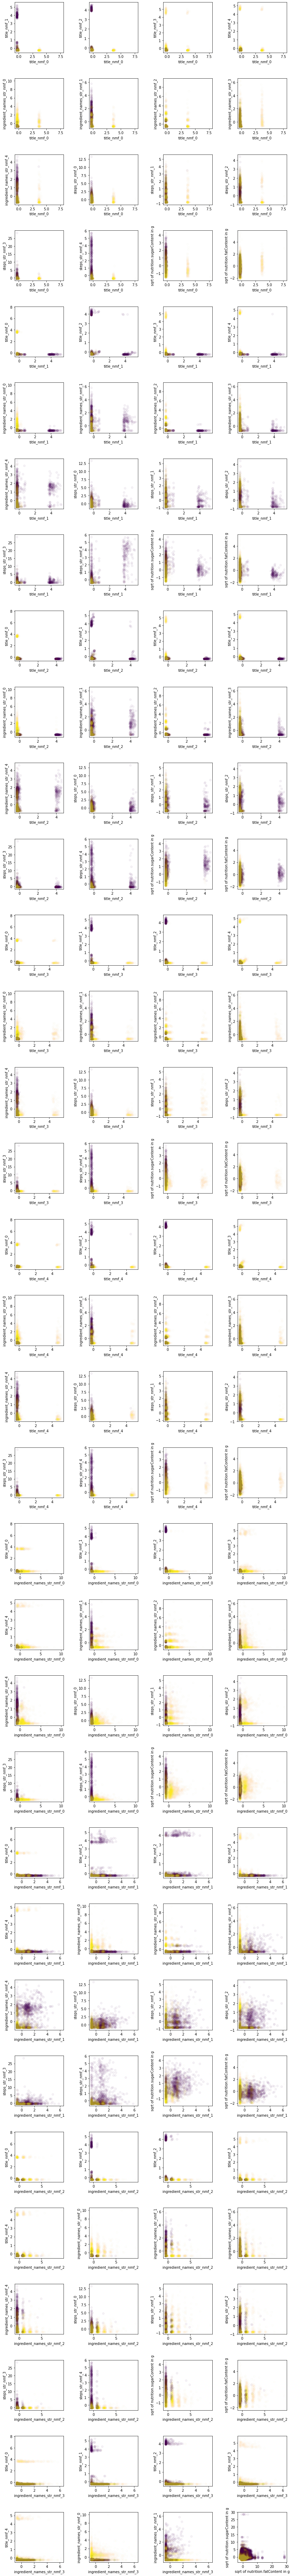

In [612]:
# get plotting

fig, axs = plt.subplots(n_plot_columns, n_plots_per_row, figsize=(3*n_plots_per_row, 3*n_plot_columns), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.5, wspace=0.7)

axs = axs.ravel()

import matplotlib.pyplot as plt


axis_i = 0
# loop over columns
for col1 in columns_to_plot:
    x = df_for_cake_clust[col1].tolist()
    
    for col2 in columns_to_plot:
        if col2 != col1:
            y = df_for_cake_clust[col2].tolist()
            
            classes = df_for_cake_clust['cluster_label'].tolist()

            unique = list(set(classes))
            colors = [plt.cm.viridis(float(i)/max(unique)) for i in unique]
            for i, u in enumerate(unique):
                xi = [x[j] for j  in range(len(x)) if classes[j] == u]
                yi = [y[j] for j  in range(len(x)) if classes[j] == u]
                
                # adjust transparency: make the dominant cluster more transparent
                # (Ig fishy, but else can be hard to see)
                if u == dominant_cluster:
                    alpha = 0.01
                else:
                    alpha = 0.05
                axs[axis_i].scatter(xi, yi, color=colors[i], label=f'cluster_label = {str(u)}', alpha=alpha)

                axs[axis_i].set_xlabel(f'{col1}')
                axs[axis_i].set_ylabel(f'{col2}')
                # plt.legend(bbox_to_anchor=(1.4, 1))
             
                # show legend for the last plot - how??
                # if axis_i == (n_plots - 1):
                    
                       
            # don't want to overshoot, otherwise jupyter shows an unsightly error
            # (that doesn't actually do anything bad, just doesn't look nice)
            if axis_i < (n_plots - 1):
                axis_i += 1

plt.tight_layout()
plt.show()

## Let's see if clustering can differentiate between cake-like things and other stuff:<br>2. Use only the "cakey" features

In [613]:
# select column names

# cakey nmf features
nmf_cols = ['title_nmf_1', 'title_nmf_2', 'title_nmf_6', 'title_nmf_7',
           'ingredient_names_str_nmf_1', 'ingredient_names_str_nmf_4', 'ingredient_names_str_nmf_9',
           'steps_str_nmf_4', 'steps_str_nmf_8']
nutritional_features = ['nutrition.sugarContent in g', 'nutrition.fatContent in g']
selected_features = nmf_cols + nutritional_features

# select columns
df_for_cake_clust = df[selected_features]
display(df_for_cake_clust.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   title_nmf_1                  3391 non-null   float64
 1   title_nmf_2                  3391 non-null   float64
 2   title_nmf_6                  3391 non-null   float64
 3   title_nmf_7                  3391 non-null   float64
 4   ingredient_names_str_nmf_1   3391 non-null   float64
 5   ingredient_names_str_nmf_4   3391 non-null   float64
 6   ingredient_names_str_nmf_9   3391 non-null   float64
 7   steps_str_nmf_4              3391 non-null   float64
 8   steps_str_nmf_8              3391 non-null   float64
 9   nutrition.sugarContent in g  3391 non-null   float64
 10  nutrition.fatContent in g    3391 non-null   float64
dtypes: float64(11)
memory usage: 477.9 KB


None

In [614]:
# sqrt transform fat & sugar content to reduce the dynamic range

for col in nutritional_features:
    new_col = np.sqrt(df_for_cake_clust[col])
    new_col_name = f'sqrt of {col}'
    df_for_cake_clust[new_col_name] = new_col
    df_for_cake_clust.drop(col, axis=1, inplace=True)
    
df_for_cake_clust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   title_nmf_1                          3391 non-null   float64
 1   title_nmf_2                          3391 non-null   float64
 2   title_nmf_6                          3391 non-null   float64
 3   title_nmf_7                          3391 non-null   float64
 4   ingredient_names_str_nmf_1           3391 non-null   float64
 5   ingredient_names_str_nmf_4           3391 non-null   float64
 6   ingredient_names_str_nmf_9           3391 non-null   float64
 7   steps_str_nmf_4                      3391 non-null   float64
 8   steps_str_nmf_8                      3391 non-null   float64
 9   sqrt of nutrition.sugarContent in g  3391 non-null   float64
 10  sqrt of nutrition.fatContent in g    3391 non-null   float64
dtypes: float64(11)
memory usag

<ipython-input-614-8bea79e8def7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_cake_clust[new_col_name] = new_col
/home/bkotryna/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [615]:
# standardise all features (assume normal distribution; mean=0, variance=1)

display(df_for_cake_clust.describe())
df_columns = df_for_cake_clust.columns

from sklearn import preprocessing
df_for_cake_clust = preprocessing.StandardScaler().fit_transform(df_for_cake_clust)

# skleanr output is np array. make it into a pd df:
df_for_cake_clust = pd.DataFrame(data=df_for_cake_clust, columns=df_columns)

display(df_for_cake_clust.describe())

title_nmf_1  title_nmf_2  title_nmf_6  title_nmf_7  \
count  3391.000000  3391.000000  3391.000000  3391.000000   
mean      0.016157     0.018466     0.013879     0.015675   
std       0.059762     0.067611     0.057149     0.065297   
min       0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000   
75%       0.001107     0.002806     0.003660     0.001670   
max       0.332882     0.326826     0.366524     0.388578   

       ingredient_names_str_nmf_1  ingredient_names_str_nmf_4  \
count                 3391.000000                 3391.000000   
mean                     0.080971                    0.061547   
std                      0.109651                    0.085344   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.012124                    0.016431   
75%                      0.153096                    0.126275   
max                      0.765837                    0.454401   

       ingredient_names_str_nmf_9  steps_str_nmf_4  steps_str_nmf_8  \
count                 3391.000000      3391.000000      3391.000000   
mean                     0.053033         0.067878         0.069898   
std                      0.088925         0.169808         0.141055   
min                      0.000000         0.000000         0.000000   
25%                      0.000000         0.000000         0.000000   
50%                      0.005502         0.000872         0.007036   
75%                      0.066527         0.043945         0.066358   
max                      0.567053         1.039017         1.083125   

       sqrt of nutrition.sugarContent in g  sqrt of nutrition.fatContent in g  
count                          3391.000000                        3391.000000  
mean                              3.108001                           3.700924  
std                               1.855408                           1.786333  
min                               0.000000                           0.000000  
25%                               1.732051                           2.469818  
50%                               2.683282                           3.660601  
75%                               4.224922                           4.878524  
max                              11.072488                          13.557286

title_nmf_1   title_nmf_2   title_nmf_6   title_nmf_7  \
count  3.391000e+03  3.391000e+03  3.391000e+03  3.391000e+03   
mean   9.551487e-16 -9.594213e-16  1.023887e-15 -1.331793e-15   
std    1.000147e+00  1.000147e+00  1.000147e+00  1.000147e+00   
min   -2.703950e-01 -2.731539e-01 -2.428872e-01 -2.400873e-01   
25%   -2.703950e-01 -2.731539e-01 -2.428872e-01 -2.400873e-01   
50%   -2.703950e-01 -2.731539e-01 -2.428872e-01 -2.400873e-01   
75%   -2.518700e-01 -2.316483e-01 -1.788304e-01 -2.145141e-01   
max    5.300524e+00  4.561451e+00  6.171569e+00  5.711682e+00   

       ingredient_names_str_nmf_1  ingredient_names_str_nmf_4  \
count                3.391000e+03                3.391000e+03   
mean                 8.325199e-16               -5.736753e-16   
std                  1.000147e+00                1.000147e+00   
min                 -7.385487e-01               -7.212641e-01   
25%                 -7.385487e-01               -7.212641e-01   
50%                 -6.279631e-01               -5.287070e-01   
75%                  6.578615e-01                7.585453e-01   
max                  6.246777e+00                4.603835e+00   

       ingredient_names_str_nmf_9  steps_str_nmf_4  steps_str_nmf_8  \
count                3.391000e+03     3.391000e+03     3.391000e+03   
mean                -2.900134e-16    -1.881109e-15    -7.553838e-16   
std                  1.000147e+00     1.000147e+00     1.000147e+00   
min                 -5.964707e-01    -3.997906e-01    -4.956091e-01   
25%                 -5.964707e-01    -3.997906e-01    -4.956091e-01   
50%                 -5.345942e-01    -3.946571e-01    -4.457176e-01   
75%                  1.517689e-01    -1.409596e-01    -2.509812e-02   
max                  5.781249e+00     5.719887e+00     7.184271e+00   

       sqrt of nutrition.sugarContent in g  sqrt of nutrition.fatContent in g  
count                         3.391000e+03                       3.391000e+03  
mean                         -1.570142e-16                       4.100066e-16  
std                           1.000147e+00                       1.000147e+00  
min                          -1.675350e+00                      -2.072105e+00  
25%                          -7.416980e-01                      -6.892826e-01  
50%                          -2.289424e-01                      -2.257661e-02  
75%                           6.020702e-01                       6.593248e-01  
max                           4.293213e+00                       5.518464e+00

In [616]:
# do k-means clustering

from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=2)
cluster_assignments = clusterer.fit_predict(df_for_cake_clust)

In [617]:
# do agglomerative clustering

# from sklearn.cluster import AgglomerativeClustering

# clusterer = AgglomerativeClustering(n_clusters=2)
# cluster_assignments = clusterer.fit_predict(df_for_cake_clust)

In [618]:
# add cluster labels into the df

df_for_cake_clust['cluster_label'] = cluster_assignments

In [619]:
# check cluster centres

clusterer.cluster_centers_

array([[-0.23478267, -0.22655067, -0.08817971, -0.18931986, -0.26576637,
        -0.31613402, -0.38368165, -0.28568882, -0.3230718 , -0.2290142 ,
         0.02870695],
       [ 0.8573271 ,  0.82726733,  0.32199504,  0.69131616,  0.97046648,
         1.15438789,  1.40104328,  1.04321488,  1.17972172,  0.83626309,
        -0.10482564]])

In [620]:
# choose columns to plot

# don't plot the cluster label
columns_to_plot = [col for col in df_for_cake_clust.columns if col != 'cluster_label']

display(columns_to_plot)

# check how many plots this would give us
n_plots = int(len(columns_to_plot) * (len(columns_to_plot) - 1) / 2)
display(f'Number of plots: {n_plots}')

['title_nmf_1',
 'title_nmf_2',
 'title_nmf_6',
 'title_nmf_7',
 'ingredient_names_str_nmf_1',
 'ingredient_names_str_nmf_4',
 'ingredient_names_str_nmf_9',
 'steps_str_nmf_4',
 'steps_str_nmf_8',
 'sqrt of nutrition.sugarContent in g',
 'sqrt of nutrition.fatContent in g']

'Number of plots: 55'

In [621]:
# check how many recipes in each cluster

df_for_cake_clust['cluster_label'].value_counts()

0    2663
1     728
Name: cluster_label, dtype: int64

In [622]:
# which cluster is dominating

if df_for_cake_clust['cluster_label'].sum() <= (len(df_for_cake_clust['cluster_label']) / 2):
    dominant_cluster = 0
else:
    dominant_cluster = 1
    
print(dominant_cluster)

0


In [623]:
# let's explore what the clusters may reperesent => make scatter plots
# check all combinations of axes
# use subplots

In [624]:
# set up subplot numbers for plt

n_plots_per_row = 4
print(n_plots_per_row)

# number of columns = n_plots / n_plots_per_row and round up
n_plot_columns = n_plots // n_plots_per_row + (n_plots % n_plots_per_row > 0)
print(n_plot_columns)

4
14


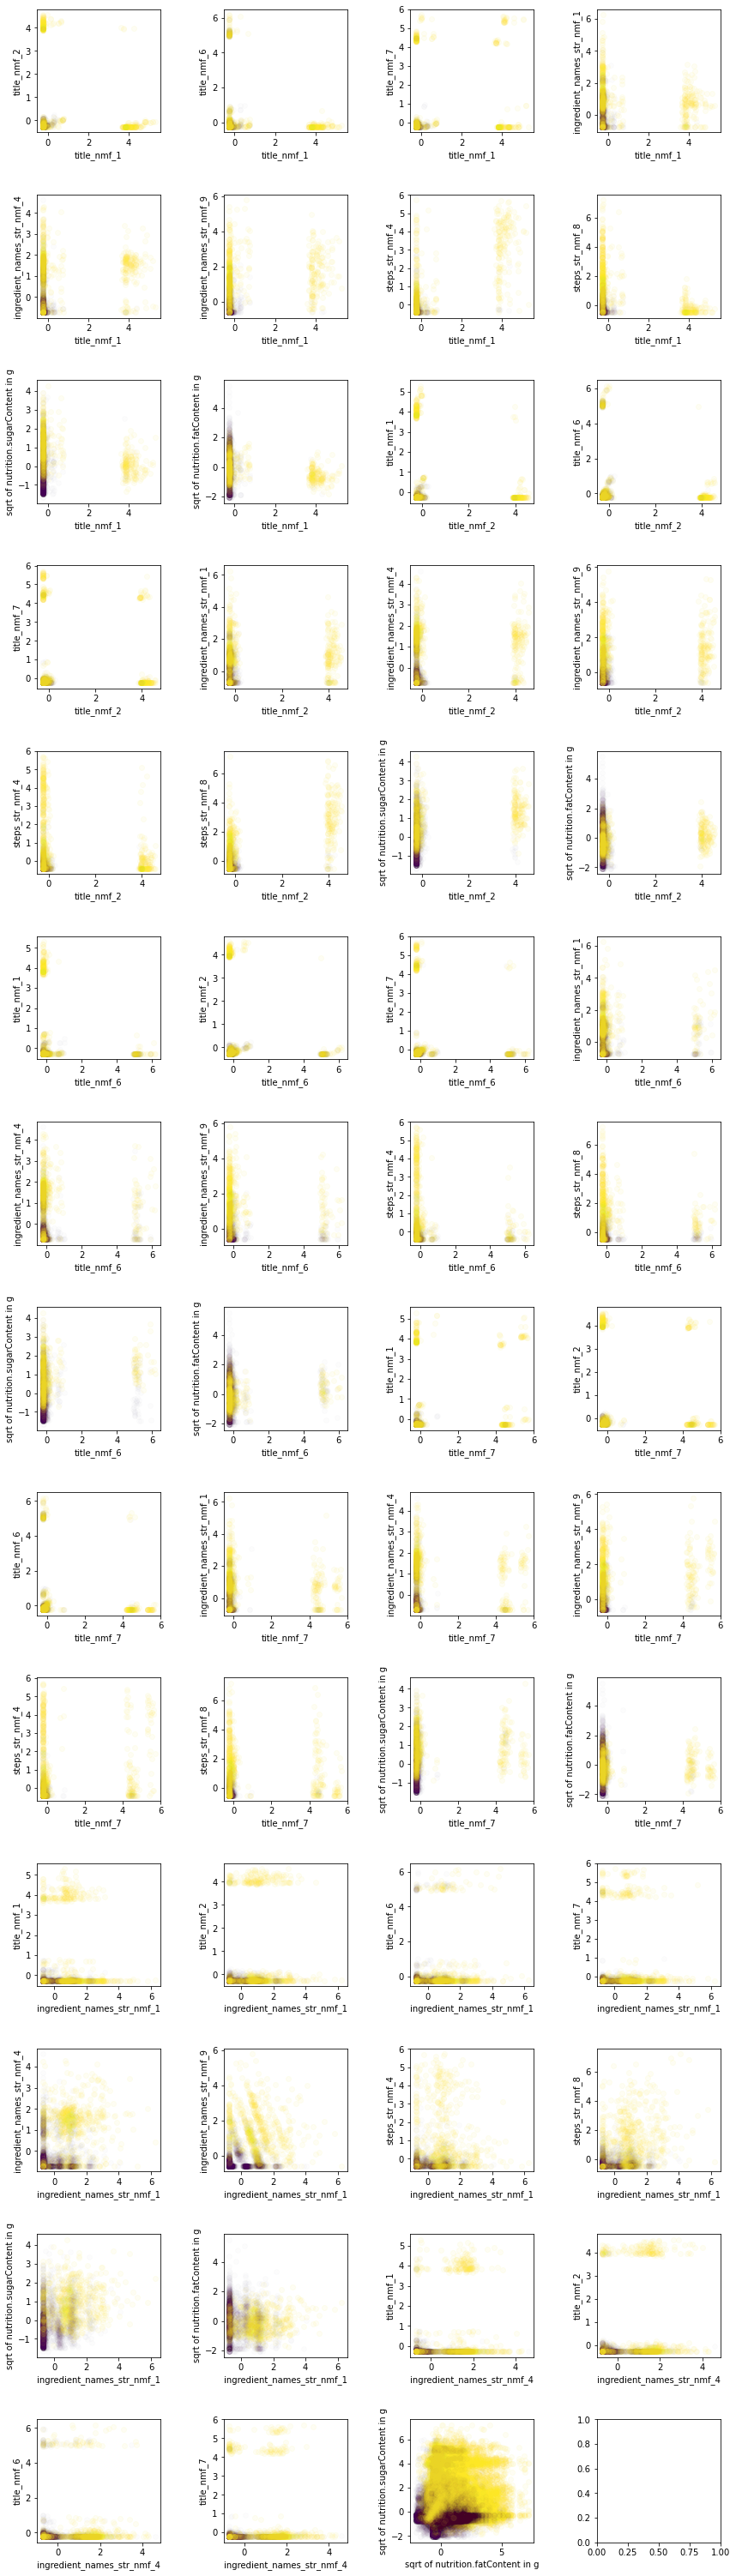

In [625]:
# get plotting

fig, axs = plt.subplots(n_plot_columns, n_plots_per_row, figsize=(3*n_plots_per_row, 3*n_plot_columns), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.5, wspace=0.7)

axs = axs.ravel()

import matplotlib.pyplot as plt


axis_i = 0
# loop over columns
for col1 in columns_to_plot:
    x = df_for_cake_clust[col1].tolist()
    
    for col2 in columns_to_plot:
        if col2 != col1:
            y = df_for_cake_clust[col2].tolist()
            
            classes = df_for_cake_clust['cluster_label'].tolist()

            unique = list(set(classes))
            colors = [plt.cm.viridis(float(i)/max(unique)) for i in unique]
            for i, u in enumerate(unique):
                xi = [x[j] for j  in range(len(x)) if classes[j] == u]
                yi = [y[j] for j  in range(len(x)) if classes[j] == u]
                
                # adjust transparency: make the dominant cluster more transparent
                # (Ig fishy, but else can be hard to see)
                if u == dominant_cluster:
                    alpha = 0.01
                else:
                    alpha = 0.05
                axs[axis_i].scatter(xi, yi, color=colors[i], label=f'cluster_label = {str(u)}', alpha=alpha)

                axs[axis_i].set_xlabel(f'{col1}')
                axs[axis_i].set_ylabel(f'{col2}')
                # plt.legend(bbox_to_anchor=(1.4, 1))
             
                # show legend for the last plot - how??
                # if axis_i == (n_plots - 1):
                    
                       
            # don't want to overshoot, otherwise jupyter shows an unsightly error
            # (that doesn't actually do anything bad, just doesn't look nice)
            if axis_i < (n_plots - 1):
                axis_i += 1

plt.tight_layout()
plt.show()

### Let's see if clustering can differentiate between cake-like things and other stuff:<br>3. Use only a couple (cakey) features

In [626]:
# select column names

# cakey nmf features
nmf_cols = ['ingredient_names_str_nmf_1', 'ingredient_names_str_nmf_4']
nutritional_features = ['nutrition.sugarContent in g', 'nutrition.fatContent in g']
selected_features = nmf_cols + nutritional_features

# select columns
df_for_cake_clust = df[selected_features]
display(df_for_cake_clust.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ingredient_names_str_nmf_1   3391 non-null   float64
 1   ingredient_names_str_nmf_4   3391 non-null   float64
 2   nutrition.sugarContent in g  3391 non-null   float64
 3   nutrition.fatContent in g    3391 non-null   float64
dtypes: float64(4)
memory usage: 292.5 KB


None

In [627]:
# sqrt transform fat & sugar content to reduce the dynamic range

for col in nutritional_features:
    new_col = np.sqrt(df_for_cake_clust[col])
    new_col_name = f'sqrt of {col}'
    df_for_cake_clust[new_col_name] = new_col
    df_for_cake_clust.drop(col, axis=1, inplace=True)
    
df_for_cake_clust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3391 entries, 10004 to 9954
Data columns (total 4 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ingredient_names_str_nmf_1           3391 non-null   float64
 1   ingredient_names_str_nmf_4           3391 non-null   float64
 2   sqrt of nutrition.sugarContent in g  3391 non-null   float64
 3   sqrt of nutrition.fatContent in g    3391 non-null   float64
dtypes: float64(4)
memory usage: 292.5 KB


<ipython-input-627-8bea79e8def7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_cake_clust[new_col_name] = new_col
/home/bkotryna/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [628]:
# standardise all features (assume normal distribution; mean=0, variance=1)

display(df_for_cake_clust.describe())
df_columns = df_for_cake_clust.columns

from sklearn import preprocessing
df_for_cake_clust = preprocessing.StandardScaler().fit_transform(df_for_cake_clust)

# skleanr output is np array. make it into a pd df:
df_for_cake_clust = pd.DataFrame(data=df_for_cake_clust, columns=df_columns)

display(df_for_cake_clust.describe())

ingredient_names_str_nmf_1  ingredient_names_str_nmf_4  \
count                 3391.000000                 3391.000000   
mean                     0.080971                    0.061547   
std                      0.109651                    0.085344   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.012124                    0.016431   
75%                      0.153096                    0.126275   
max                      0.765837                    0.454401   

       sqrt of nutrition.sugarContent in g  sqrt of nutrition.fatContent in g  
count                          3391.000000                        3391.000000  
mean                              3.108001                           3.700924  
std                               1.855408                           1.786333  
min                               0.000000                           0.000000  
25%                               1.732051                           2.469818  
50%                               2.683282                           3.660601  
75%                               4.224922                           4.878524  
max                              11.072488                          13.557286

ingredient_names_str_nmf_1  ingredient_names_str_nmf_4  \
count                3.391000e+03                3.391000e+03   
mean                 8.325199e-16               -5.736753e-16   
std                  1.000147e+00                1.000147e+00   
min                 -7.385487e-01               -7.212641e-01   
25%                 -7.385487e-01               -7.212641e-01   
50%                 -6.279631e-01               -5.287070e-01   
75%                  6.578615e-01                7.585453e-01   
max                  6.246777e+00                4.603835e+00   

       sqrt of nutrition.sugarContent in g  sqrt of nutrition.fatContent in g  
count                         3.391000e+03                       3.391000e+03  
mean                         -1.570142e-16                       4.100066e-16  
std                           1.000147e+00                       1.000147e+00  
min                          -1.675350e+00                      -2.072105e+00  
25%                          -7.416980e-01                      -6.892826e-01  
50%                          -2.289424e-01                      -2.257661e-02  
75%                           6.020702e-01                       6.593248e-01  
max                           4.293213e+00                       5.518464e+00

In [629]:
# do k-means clustering

from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=2)
cluster_assignments = clusterer.fit_predict(df_for_cake_clust)

In [630]:
# do agglomerative clustering

# from sklearn.cluster import AgglomerativeClustering

# clusterer = AgglomerativeClustering(n_clusters=2)
# cluster_assignments = clusterer.fit_predict(df_for_cake_clust)

In [631]:
# add cluster labels into the df

df_for_cake_clust['cluster_label'] = cluster_assignments

In [632]:
# check cluster centres

clusterer.cluster_centers_

array([[ 1.12844041,  0.82741443,  0.7670728 , -0.19197612],
       [-0.4950392 , -0.36298113, -0.33650966,  0.08421863]])

In [633]:
# choose columns to plot

# don't plot the cluster label
columns_to_plot = [col for col in df_for_cake_clust.columns if col != 'cluster_label']

display(columns_to_plot)

# check how many plots this would give us
n_plots = int(len(columns_to_plot) * (len(columns_to_plot) - 1) / 2)
display(f'Number of plots: {n_plots}')

['ingredient_names_str_nmf_1',
 'ingredient_names_str_nmf_4',
 'sqrt of nutrition.sugarContent in g',
 'sqrt of nutrition.fatContent in g']

'Number of plots: 6'

In [634]:
# check how many recipes in each cluster

df_for_cake_clust['cluster_label'].value_counts()

1    2359
0    1032
Name: cluster_label, dtype: int64

In [635]:
# which cluster is dominating

if df_for_cake_clust['cluster_label'].sum() <= (len(df_for_cake_clust['cluster_label']) / 2):
    dominant_cluster = 0
else:
    dominant_cluster = 1
    
print(dominant_cluster)

1


In [636]:
# let's explore what the clusters may reperesent => make scatter plots
# check all combinations of axes
# use subplots

In [637]:
# set up subplot numbers for plt

n_plots_per_row = 4
print(n_plots_per_row)

# number of columns = n_plots / n_plots_per_row and round up
n_plot_columns = n_plots // n_plots_per_row + (n_plots % n_plots_per_row > 0)
print(n_plot_columns)

4
2


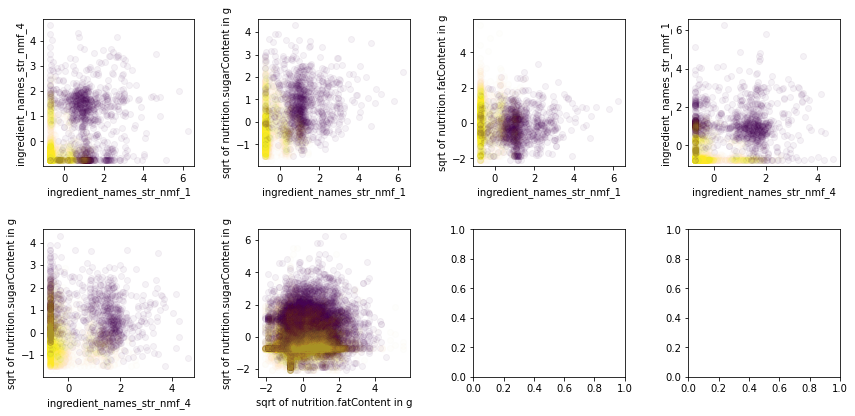

In [638]:
# get plotting

fig, axs = plt.subplots(n_plot_columns, n_plots_per_row, figsize=(3*n_plots_per_row, 3*n_plot_columns), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.5, wspace=0.7)

axs = axs.ravel()

import matplotlib.pyplot as plt


axis_i = 0
# loop over columns
for col1 in columns_to_plot:
    x = df_for_cake_clust[col1].tolist()
    
    for col2 in columns_to_plot:
        if col2 != col1:
            y = df_for_cake_clust[col2].tolist()
            
            classes = df_for_cake_clust['cluster_label'].tolist()

            unique = list(set(classes))
            colors = [plt.cm.viridis(float(i)/max(unique)) for i in unique]
            for i, u in enumerate(unique):
                xi = [x[j] for j  in range(len(x)) if classes[j] == u]
                yi = [y[j] for j  in range(len(x)) if classes[j] == u]
                
                # adjust transparency: make the dominant cluster more transparent
                # (Ig fishy, but else can be hard to see)
                if u == dominant_cluster:
                    alpha = 0.01
                else:
                    alpha = 0.05
                axs[axis_i].scatter(xi, yi, color=colors[i], label=f'cluster_label = {str(u)}', alpha=alpha)

                axs[axis_i].set_xlabel(f'{col1}')
                axs[axis_i].set_ylabel(f'{col2}')
                # plt.legend(bbox_to_anchor=(1.4, 1))
             
                # show legend for the last plot - how??
                # if axis_i == (n_plots - 1):
                    
                       
            # don't want to overshoot, otherwise jupyter shows an unsightly error
            # (that doesn't actually do anything bad, just doesn't look nice)
            if axis_i < (n_plots - 1):
                axis_i += 1

plt.tight_layout()
plt.show()

## Optional individual plotting

In [646]:
# check columns in the df => have a look and choose which particular ones to plot (if desired)
df_for_cake_clust.columns

Index(['ingredient_names_str_nmf_1', 'ingredient_names_str_nmf_4',
       'sqrt of nutrition.sugarContent in g',
       'sqrt of nutrition.fatContent in g', 'cluster_label'],
      dtype='object')

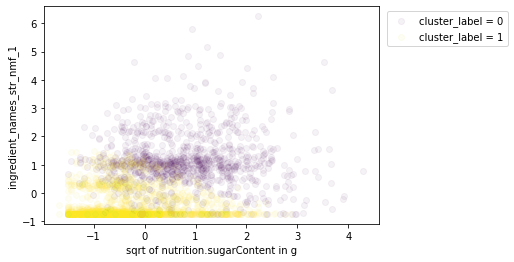

In [645]:
# check an individual plot
# option 1 = with legend

import matplotlib.pyplot as plt

# nmf_1 is the cakey component
x_value = 'sqrt of nutrition.sugarContent in g'
y_value = 'ingredient_names_str_nmf_1' 

x = df_for_cake_clust[x_value].tolist()
y = df_for_cake_clust[y_value].tolist()
classes = df_for_cake_clust['cluster_label'].tolist()

unique = list(set(classes))
colors = [plt.cm.viridis(float(i)/max(unique)) for i in unique]
for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    if u ==1:
        alpha = 0.05
    else:
        alpha = 0.05
    plt.scatter(xi, yi, color=colors[i], label=f'cluster_label = {str(u)}', alpha=alpha)
    
plt.xlabel(f'{x_value}')
plt.ylabel(f'{y_value}')
plt.legend(bbox_to_anchor=(1.4, 1))

plt.show()

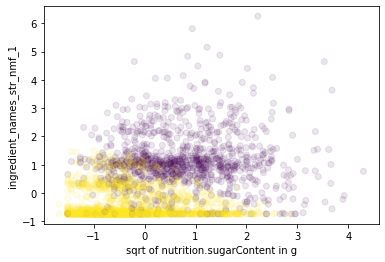

In [644]:
# check an individual plot
# option 2 = without legend

import matplotlib.pyplot as plt

x_value = 'sqrt of nutrition.sugarContent in g'
y_value = 'ingredient_names_str_nmf_1' # nmf_1 is the cakey component

#df_for_cake_clust.plot.scatter(x_value, y_value, c=df_for_cake_clust['cluster_label'], a=0.1)

fig = plt.figure()
plt.scatter(x = df_for_cake_clust[x_value],
           y = df_for_cake_clust[y_value],
           alpha = 0.1,
           c = df_for_cake_clust['cluster_label'])
plt.xlabel(f'{x_value}')
plt.ylabel(f'{y_value}')
plt.show()

## Conclusions<br>

1. <b>Predicting avg_rating</b>:
    1. Gradient Boosted Regression Tree works well
        1. Best learning_rate = 0.1:
            - mean_abs_error = 0.301
            - mean_sq_error on test = 0.192<br>
        BTW standard deviation of avg_rating on test is 0.575<br>
        => much higher than our mean_sq_error => predictor is better than random guess
        <br><br>
        1. Key features (three dominant ones):
            1. ratings_no = 0.35
            1. photo_count = 0.201
            1. reviews_no = 0.093<br>
            => These seem like they're confounded with avg_rating<br>
            eg maybe people add more photos for nice recipes
            <br><br>
    1. If we exclude the top three features mentioned above:
        1. Best learning_rate = 0.05:
            - mean_abs_error on test = 0.365
            - mean_sq_error on test = 0.313
            - BTW standard deviation of avg_rating on test is 0.575<br>
        => higher than our mean_sq_error => predictor is better than random guess
        <br><br>
        1. Key features vary depending on the learning rate. For this case only two are somewhat dominating:
            1. video_present = 0.118
            1. recipe_age = 0.080
        <br><br>
1. <b>Clustering</b>:
    1. Want to separate out cakey vs savoury foods
    <br><br>
    1. Use k-means clustering with n=2 clusters
        - Try out various combinations of features as input for this
        - sqrt transform nutritional data
        - standardise all data (mean=0, var=1)
    <br><br>
    1. Visualise clusters by plotting all xy axes combinations
        - Don't see nice separation on any of the plots